
# Supabase → Pandas – Datenaufbereitung

Dieses Notebook lädt Rohdaten aus der Supabase‑Datenbank, bereinigt sie
und erstellt ein `demographic`‑DataFrame mit:
* **Demografie‑Merkmalen** pro Gerät  
* **Axis of Opression** (Intersection‑Frage)  
* **Anzahl ausgefüllter Surveys** pro Gerät  

Gliederung  
0. Konfiguration & Bibliotheken  
1. Datenquellen laden  
2. Helferfunktionen  
3. Erste Survey je Gerät + Duplikate bereinigen  
4. Demografie‑Antworten extrahieren  
5. “Axis of Opression” ergänzen  
6. Label‑Mapping & optionale Ordinal‑Codes  
7. Anzahl Surveys pro Gerät  
8. Ergebnis prüfen / speichern


# 1 Import setup

In [1457]:

import json, numpy as np, pandas as pd, sqlalchemy as sa

# ----------------‑ DB‑Verbindung ---------------------------------------------------
DB_URI = (
    "postgresql+psycopg2://postgres.dctqoywyodnjrpnzmdnf:"
    "w4tuxVm*pHFwZCrac9Gkob2qCNJuzuXW3aR*._fhXbhz4Fzta.9P9Y8HU37!@aws-0-eu-central-2.pooler.supabase.com:5432/postgres"
    "?sslmode=require"
)
engine = sa.create_engine(DB_URI, pool_pre_ping=True)

pd.set_option("display.max_columns", None)


In [1458]:

# ---------- Surveys ---------------------------------------------------------------
surveys_df = pd.read_sql(
    '''
    SELECT id AS survey_id,
           device_id,
           completed,
           location_lat, location_lng,
           created_at
    FROM public.surveys
    ''', engine
)

# ---------- Responses -------------------------------------------------------------
responses_df = pd.read_sql(
    '''
    SELECT survey_id,
           question_id,
           response,
           created_at
    FROM public.responses
    ''', engine
)

# ---------- Questions -------------------------------------------------------------
questions_df = pd.read_sql(
    '''
    SELECT id AS question_id,
           category
    FROM public.questions
    ''', engine
)
print(len(surveys_df), "surveys,", len(responses_df), "responses")


272 surveys, 2668 responses


In [1459]:

def parse_json(val):
    """String‑JSON → Python‑Objekt (oder unverändert)."""
    try:
        return json.loads(val) if isinstance(val, str) else val
    except Exception:
        return val

def first_choice(val):
    """Erstes Element aus Liste; leere {} -> None; sonst unverändert."""
    v = parse_json(val)
    if isinstance(v, list):
        return v[0] if v else None
    if isinstance(v, dict):
        return None
    return v


In [1460]:

# a) nur completed
surv_done = surveys_df[surveys_df['completed']].copy()

# b) timestamp runden & duplicates killen
surv_done['ts_round'] = pd.to_datetime(surv_done['created_at']).dt.floor('S')
surv_done = surv_done.drop_duplicates(['device_id','ts_round'])

# c) erste survey_id pro device
first_surv_ids = (surv_done
                  .sort_values('created_at')
                  .drop_duplicates('device_id')['survey_id'])
print("Distinct devices:", first_surv_ids.nunique())


Distinct devices: 26


/var/folders/t9/hd1jk7xd203d3n6kn68m9lzc0000gn/T/ipykernel_37035/3287783094.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  surv_done['ts_round'] = pd.to_datetime(surv_done['created_at']).dt.floor('S')


In [1461]:

demo_qids = questions_df.query("category == 'demographic'")['question_id']

demo_raw = (responses_df
            .query("survey_id in @first_surv_ids and question_id in @demo_qids")
            .merge(surv_done[['survey_id','device_id']], on='survey_id'))

demo_norm = (demo_raw
             .assign(value=lambda d: d['response'].apply(first_choice))
             .sort_values(['device_id','question_id','created_at'])
             .drop_duplicates(['device_id','question_id']))

demo_wide = (demo_norm
             .pivot(index='device_id', columns='question_id', values='value')
             .replace({None: np.nan, 'None': np.nan}))
demo_wide.head()


/var/folders/t9/hd1jk7xd203d3n6kn68m9lzc0000gn/T/ipykernel_37035/1033437217.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({None: np.nan, 'None': np.nan}))


question_id,age_group,different_country_than_born_in,disabilities,education,employment_status,gender,household_members,household_members_financing,info_questions_about_you,monthly_household_income,sex,sexual_orientation
device_id,,,,,,,,,,,,
1IIJ-CDFW-46VP,age_group_2635,different_country_than_born_in_no,disabilities_no,education_university_degree,employment_status_employed,gender_male,household_members_3,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight
1SMH-8HOX-E1HX,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_5,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight
20LN-4X5H-UXWX,age_group_5665,NaN,disabilities_no,education_maturafmshms_or_equivalent,employment_status_employed,gender_trans_man,household_members_6,household_members_financing_6,NaN,monthly_household_income_chf_60007500,sex_female,sexual_orientation_asexual
4RKD-HU7N-HXI2,NaN,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_3,household_members_financing_3,NaN,monthly_household_income_chf_30004500,sex_female,sexual_orientation_straight
678K-202G-SYCD,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_1_living_alone,household_members_financing_2,NaN,monthly_household_income_less_than_chf_1500,sex_female,sexual_orientation_straight


In [1462]:

AXIS_QID = 'axis_of_opression'

axis_raw = (responses_df
            .query('question_id == @AXIS_QID and survey_id in @first_surv_ids')
            .merge(surv_done[['survey_id','device_id']], on='survey_id')
            .drop_duplicates('device_id'))

axis_raw['axis_codes'] = axis_raw['response'].apply(
    lambda x: ';'.join(parse_json(x)) if isinstance(parse_json(x), list) else None
)

axis_wide = axis_raw.set_index('device_id')[['axis_codes']]

demo_all = demo_wide.join(axis_wide, how='left')
demo_all.head()


,age_group,different_country_than_born_in,disabilities,education,employment_status,gender,household_members,household_members_financing,info_questions_about_you,monthly_household_income,sex,sexual_orientation,axis_codes
device_id,,,,,,,,,,,,,
1IIJ-CDFW-46VP,age_group_2635,different_country_than_born_in_no,disabilities_no,education_university_degree,employment_status_employed,gender_male,household_members_3,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight,axis_of_opression_no
1SMH-8HOX-E1HX,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_5,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight,axis_of_opression_yes_because_of_my_social_or_...
20LN-4X5H-UXWX,age_group_5665,NaN,disabilities_no,education_maturafmshms_or_equivalent,employment_status_employed,gender_trans_man,household_members_6,household_members_financing_6,NaN,monthly_household_income_chf_60007500,sex_female,sexual_orientation_asexual,axis_of_opression_yes_because_of_my_clothing_o...
4RKD-HU7N-HXI2,NaN,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_3,household_members_financing_3,NaN,monthly_household_income_chf_30004500,sex_female,sexual_orientation_straight,axis_of_opression_no
678K-202G-SYCD,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_1_living_alone,household_members_financing_2,NaN,monthly_household_income_less_than_chf_1500,sex_female,sexual_orientation_straight,None


In [1463]:

AGE_GROUP = {
    "age_group_1625": "16–25",
    # ...
}
DECODER = {'age_group': AGE_GROUP}
for col, mapping in DECODER.items():
    if col in demo_all.columns:
        demo_all[f"{col}_lbl"] = demo_all[col].map(mapping)


In [1464]:

survey_counts = (surv_done
                 .groupby('device_id')['survey_id']
                 .nunique()
                 .rename('n_surveys'))
demo_all['n_surveys'] = survey_counts
demo_all['n_surveys'] = demo_all['n_surveys'].fillna(0).astype(int)
demo_all[['n_surveys']].describe()


,n_surveys
count,26.000000
mean,4.115385
std,2.916531
min,1.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,12.000000


In [1465]:

print("Final shape:", demo_all.shape)
demo_all.head()

demo_all


Final shape: (26, 15)


,age_group,different_country_than_born_in,disabilities,education,employment_status,gender,household_members,household_members_financing,info_questions_about_you,monthly_household_income,sex,sexual_orientation,axis_codes,age_group_lbl,n_surveys
device_id,,,,,,,,,,,,,,,
1IIJ-CDFW-46VP,age_group_2635,different_country_than_born_in_no,disabilities_no,education_university_degree,employment_status_employed,gender_male,household_members_3,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight,axis_of_opression_no,NaN,4
1SMH-8HOX-E1HX,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_5,household_members_financing_2,NaN,monthly_household_income_more_than_chf_10000,sex_female,sexual_orientation_straight,axis_of_opression_yes_because_of_my_social_or_...,16–25,3
20LN-4X5H-UXWX,age_group_5665,NaN,disabilities_no,education_maturafmshms_or_equivalent,employment_status_employed,gender_trans_man,household_members_6,household_members_financing_6,NaN,monthly_household_income_chf_60007500,sex_female,sexual_orientation_asexual,axis_of_opression_yes_because_of_my_clothing_o...,NaN,1
4RKD-HU7N-HXI2,NaN,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_3,household_members_financing_3,NaN,monthly_household_income_chf_30004500,sex_female,sexual_orientation_straight,axis_of_opression_no,NaN,1
678K-202G-SYCD,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_1_living_alone,household_members_financing_2,NaN,monthly_household_income_less_than_chf_1500,sex_female,sexual_orientation_straight,None,16–25,4
9ETT-XPT5-3C80,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_3,household_members_financing_2,NaN,monthly_household_income_less_than_chf_1500,sex_female,sexual_orientation_straight,axis_of_opression_no,16–25,2
AV26-LBWO-90SG,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_3,household_members_financing_3,NaN,monthly_household_income_chf_15003000,sex_female,sexual_orientation_homosexual,axis_of_opression_yes_because_of_my_sexual_ori...,16–25,7
BM8A-0EWF-AVZ7,age_group_2635,different_country_than_born_in_yes,disabilities_no,education_university_degree,employment_status_pupil__student,gender_female,household_members_9,household_members_financing_1_person_myself_only,NaN,monthly_household_income_chf_30004500,sex_male,sexual_orientation_straight,axis_of_opression_yes_because_of_my_gender,NaN,5
EHDA-B0DC-JY1G,age_group_1625,different_country_than_born_in_no,disabilities_no,education_maturafmshms_or_equivalent,employment_status_pupil__student,gender_male,household_members_4,household_members_financing_2,NaN,monthly_household_income_less_than_chf_1500,sex_female,sexuql_orientation_bisexual,axis_of_opression_yes_because_of_my_language_o...,16–25,2


In [1466]:
import pandas as pd
import numpy as np
from typing import Dict

# ------------------------------------------------------------------
# 1) Nachschlage-Dictionaries
# ------------------------------------------------------------------
AGE_GROUP = {
    "age_group_under_16": "< 16",
    "age_group_1625":     "16 – 25",
    "age_group_2635":     "26 – 35",
    "age_group_3645":     "36 – 45",
    "age_group_4655":     "46 – 55",
    "age_group_5665":     "56 – 65",
    "age_group_6675":     "66 – 75",
    "age_group_75":       "75 +",
}

SEX = {
    "sex_male":   "male",
    "sex_female": "female",
    "sex_inter":  "inter*/diverse",
}

GENDER = {
    "gender_female":                "woman",
    "gender_male":                  "man",
    "gender_nonbinary_genderqueer": "non-binary / gender-queer",
    "gender_trans_woman":           "trans woman",
    "gender_trans_man":             "trans man",
    "gender_agender":               "agender",
    "gender_inter":                 "inter* / diverse",
    "gender_other":                 "other",
}

SEXUAL_ORIENTATION = {
    "sexual_orientation_straight":   "straight / hetero",
    "sexual_orientation_homosexual": "gay / lesbian",
    # Tippfehler aus den Rohdaten mit abfangen:
    "sexuql_orientation_bisexual":   "bisexual",
    "sexual_orientation_bisexual":   "bisexual",
    "sexual_orientation_pansexual":  "pansexual",
    "sexual_orientation_asexual":    "asexual",
    "sexual_orientation_queer":      "queer",
    "sexual_orientation_other":      "other",
}

EDUCATION = {
    "education_none":                                   "no formal education",
    "education_secondary_school":                       "secondary school",
    "education_vocational_training_or_apprenticeship":  "vocational training / apprenticeship",
    "education_maturafmshms_or_equivalent":             "Matura / equivalent",
    "education_university_of_applied_sciences_fhhf":    "university of applied sciences",
    "education_university_degree":                      "university degree",
}

HOUSEHOLD_MEMBERS = {
    "household_members_1_living_alone": "1 (living alone)",
    "household_members_2":              "2",
    "household_members_3":              "3",
    "household_members_4":              "4",
    "household_members_5":              "5",
    "household_members_6":              "6",
    "household_members_7":              "7",
    "household_members_8":              "8",
    "household_members_9":              "9",
    "household_members_10_or_more":     "10+",
}

HOUSEHOLD_FINANCING = {
    "household_members_financing_1_person_myself_only": "1 earner (myself)",
    "household_members_financing_2":                    "2 earners",
    "household_members_financing_3":                    "3 earners",
    "household_members_financing_4":                    "4 earners",
    "household_members_financing_5":                    "5 earners",
    "household_members_financing_6":                    "6 earners",
    "household_members_financing_7":                    "7 earners",
    "household_members_financing_8":                    "8 earners",
    "household_members_financing_9":                    "9 earners",
    "household_members_financing_10_or_more":           "10+ earners",
}

HOUSEHOLD_INCOME = {
    "monthly_household_income_less_than_chf_1500":      "< CHF 1 500",
    "monthly_household_income_chf_15003000":            "CHF 1 500 – 3 000",
    "monthly_household_income_chf_30004500":            "CHF 3 000 – 4 500",
    "monthly_household_income_chf_45006000":            "CHF 4 500 – 6 000",
    "monthly_household_income_chf_60007500":            "CHF 6 000 – 7 500",
    "monthly_household_income_chf_750010000":           "CHF 7 500 – 10 000",
    "monthly_household_income_more_than_chf_10000":     "> CHF 10 000",
    "monthly_household_income_unknown":                 "unknown / prefer not to say",
}

EMPLOYMENT_STATUS = {
    "employment_status_pupil__student": "student / pupil",
    "employment_status_employed":       "employed",
    "employment_status_selfemployed":   "self-employed",
    "employment_status_retired":        "retired",
    "employment_status_unemployed":     "unemployed",
}

AXIS_MAP = {
    "axis_of_opression_yes_because_of_my_gender":                        "gender",
    "axis_of_opression_yes_because_of_my_age":                           "age",
    "axis_of_opression_yes_because_of_my_background":                    "background",
    "axis_of_opression_yes_because_of_my_skin_colour_or_appearance":     "skin / appearance",
    "axis_of_opression_yes_because_of_my_language_or_accent":            "language / accent",
    "axis_of_opression_yes_because_of_my_social_or_financial_situation": "social / financial",
    "axis_of_opression_yes_because_of_my_clothing_or_style":             "clothing / style",
    "axis_of_opression_yes_because_of_my_sexual_orientation":            "sexual orientation",
    "axis_of_opression_yes_because_of_my_health_condition_or_a_disability": "health / disability",
    "axis_of_opression_yes_for_another_reason":                          "other reason",
    "axis_of_opression_no":                                              "no",
}

DISABILITIES = {
    "disabilities_yes": "yes",
    "disabilities_no":  "no",
}

DIFF_COUNTRY = {
    "different_country_than_born_in_yes": "yes",
    "different_country_than_born_in_no":  "no",
}

# Haupt-Mapping: Spaltenname -> Mapping
DECODER: Dict[str, Dict[str, str]] = {
    "age_group":                      AGE_GROUP,
    "sex":                            SEX,
    "gender":                         GENDER,
    "sexual_orientation":             SEXUAL_ORIENTATION,
    "education":                      EDUCATION,
    "household_members":              HOUSEHOLD_MEMBERS,
    "household_members_financing":    HOUSEHOLD_FINANCING,
    "monthly_household_income":       HOUSEHOLD_INCOME,
    "employment_status":              EMPLOYMENT_STATUS,
    "disabilities":                   DISABILITIES,
    "axis_codes":                     AXIS_MAP,
    "different_country_than_born_in": DIFF_COUNTRY,
}

# ------------------------------------------------------------------
# 2) Funktionen
# ------------------------------------------------------------------
def decode_value(val, mapping: Dict[str, str], sep_in=";", sep_out=";"):
    """Codes -> Labels; unterstützt Mehrfachantworten mit sep_in."""
    if pd.isna(val):
        return np.nan
    parts = [p.strip() for p in str(val).split(sep_in) if p.strip() != ""]
    return sep_out.join(mapping.get(p, p) for p in parts) if parts else np.nan

def decode_columns(df: pd.DataFrame,
                   decoder: Dict[str, Dict[str, str]],
                   suffix="_lbl",
                   overwrite=True,
                   sep_in=";",
                   sep_out=";") -> pd.DataFrame:
    """Dekodiert alle im decoder angegebenen Spalten.
       overwrite=True überschreibt bestehende *_lbl-Spalten.
    """
    out = df.copy()
    for col, mapping in decoder.items():
        if col not in out.columns:
            continue
        lbl_col = f"{col}{suffix}"
        if (not overwrite) and (lbl_col in out.columns):
            continue
        out[lbl_col] = out[col].apply(lambda v: decode_value(v, mapping, sep_in, sep_out))
    return out

def find_unmapped(df: pd.DataFrame, col: str, mapping: Dict[str, str], sep_in=";"):
    """Zeigt Werte, für die kein Mapping existiert."""
    if col not in df.columns:
        return []
    vals = (df[col].dropna().astype(str)
            .str.split(sep_in)
            .explode()
            .str.strip()
            .unique())
    return sorted(set(vals) - set(mapping.keys()))

def report_all_unmapped(df: pd.DataFrame, decoder: Dict[str, Dict[str, str]], sep_in=";"):
    """Sammelt fehlende Codes aller Spalten."""
    res = {}
    for col, mapping in decoder.items():
        if col in df.columns:
            miss = find_unmapped(df, col, mapping, sep_in)
            if miss:
                res[col] = miss
    return res

# ------------------------------------------------------------------
# 3) Anwendung (Beispiel)
# ------------------------------------------------------------------
demo_all = decode_columns(demo_all, DECODER, suffix="_lbl", overwrite=True)
print(report_all_unmapped(demo_all, DECODER))

# Alle Roh-Code-Spalten aus dem DECODER entfernen – aber nur, wenn es die *_lbl schon gibt
raw_cols = list(DECODER.keys())
to_drop = [c for c in raw_cols if f"{c}_lbl" in demo_all.columns]

demo_all = demo_all.drop(columns=to_drop, errors="ignore")

demo_all = demo_all.drop(columns=["info_questions_about_you"], errors="ignore")

suffix = "_lbl"
rename_map = {c: c[:-len(suffix)] for c in demo_all.columns if c.endswith(suffix)}
demo_all = demo_all.rename(columns=rename_map)

# Entfernen einer Person welche nur eine Frage mit Nein beantwortet hat, alles andere weiter geklickt hat
demo_all = demo_all.drop(index="YPJ1-0ZZ5-ZZTJ")

# Einkommenskategorien
INCOME_MIDPOINTS = {
    "< CHF 1 500": 750,
    "CHF 1 500 – 3 000": 2250,
    "CHF 3 000 – 4 500": 3750,
    "CHF 4 500 – 6 000": 5250,
    "CHF 6 000 – 7 500": 6750,
    "CHF 7 500 – 10 000": 8750,
    "> CHF 10 000": 11000,
    "unknown / prefer not to say": np.nan,
}

def parse_household_members(value: str) -> float:
    if value == "1 (living alone)":
        return 1
    elif value == "10+":
        return 10
    else:
        try:
            return float(value)
        except:
            return np.nan

def oecd_equivalence_scale(members: float) -> float:
    if pd.isna(members):
        return np.nan
    return 1.0 + 0.5 * (members - 1)

def group_eq_income(value: float) -> str:
    if pd.isna(value):
        return "Unknown"
    elif value < 1000:
        return "Very Low"
    elif value < 2000:
        return "Low"
    elif value < 3000:
        return "Middle"
    elif value < 5000:
        return "High"
    else:
        return "Very High"

# --- Schritt 2: Anwendung auf DataFrame -------------------------------------------

demo_all["hh_members"] = demo_all["household_members"].apply(parse_household_members)

demo_all["income_mid"] = demo_all["monthly_household_income"].map(INCOME_MIDPOINTS)

demo_all["eq_scale"] = demo_all["hh_members"].apply(oecd_equivalence_scale)

demo_all["eq_income"] = demo_all["income_mid"] / demo_all["eq_scale"]

demo_all["eq_income_group"] = demo_all["eq_income"].apply(group_eq_income)


people_data = demo_all
people_data.to_csv("people_data.csv", index=True)
people_data



{}


,age_group,n_surveys,sex,gender,sexual_orientation,education,household_members,household_members_financing,monthly_household_income,employment_status,disabilities,axis_codes,different_country_than_born_in,hh_members,income_mid,eq_scale,eq_income,eq_income_group
device_id,,,,,,,,,,,,,,,,,,
1IIJ-CDFW-46VP,26 – 35,4,female,man,straight / hetero,university degree,3,2 earners,> CHF 10 000,employed,no,no,no,3.0,11000.0,2.0,5500.000000,Very High
1SMH-8HOX-E1HX,16 – 25,3,female,man,straight / hetero,Matura / equivalent,5,2 earners,> CHF 10 000,student / pupil,no,social / financial,no,5.0,11000.0,3.0,3666.666667,High
20LN-4X5H-UXWX,56 – 65,1,female,trans man,asexual,Matura / equivalent,6,6 earners,CHF 6 000 – 7 500,employed,no,clothing / style,NaN,6.0,6750.0,3.5,1928.571429,Low
4RKD-HU7N-HXI2,NaN,1,female,man,straight / hetero,Matura / equivalent,3,3 earners,CHF 3 000 – 4 500,student / pupil,no,no,no,3.0,3750.0,2.0,1875.000000,Low
678K-202G-SYCD,16 – 25,4,female,man,straight / hetero,Matura / equivalent,1 (living alone),2 earners,< CHF 1 500,student / pupil,no,NaN,no,1.0,750.0,1.0,750.000000,Very Low
9ETT-XPT5-3C80,16 – 25,2,female,man,straight / hetero,Matura / equivalent,3,2 earners,< CHF 1 500,student / pupil,no,no,no,3.0,750.0,2.0,375.000000,Very Low
AV26-LBWO-90SG,16 – 25,7,female,man,gay / lesbian,Matura / equivalent,3,3 earners,CHF 1 500 – 3 000,student / pupil,no,sexual orientation,no,3.0,2250.0,2.0,1125.000000,Low
BM8A-0EWF-AVZ7,26 – 35,5,male,woman,straight / hetero,university degree,9,1 earner (myself),CHF 3 000 – 4 500,student / pupil,no,gender,yes,9.0,3750.0,5.0,750.000000,Very Low
EHDA-B0DC-JY1G,16 – 25,2,female,man,bisexual,Matura / equivalent,4,2 earners,< CHF 1 500,student / pupil,no,language / accent;sexual orientation,no,4.0,750.0,2.5,300.000000,Very Low


# 2 Surveydaten

In [1467]:
import json, numpy as np, pandas as pd

# ------------------------------------------------------------------
# 1) Survey-Meta   (fertig abgeschlossene Befragungen)
# ------------------------------------------------------------------
sv_done = (
    surveys_df
    .loc[surveys_df["completed"]]                       # nur fertig
    .sort_values(["device_id", "created_at"])
    .assign(survey_num=lambda d: d.groupby("device_id").cumcount() + 1)
)

meta = (
    sv_done[["survey_id", "device_id", "survey_num",
             "created_at", "location_lat", "location_lng"]]
    .rename(columns={"created_at": "survey_created_at"})
)

# ------------------------------------------------------------------
# 2) Frage-IDs, die *nicht* Demografie sind  (= wiederholt)
# ------------------------------------------------------------------
repeated_qids = questions_df.loc[
    ~questions_df["category"].eq("demographic"), "question_id"
]

# ------------------------------------------------------------------
# 3) Robuster Parser für die response-Spalte
# ------------------------------------------------------------------
def clean_rsp(val):
    if val is None or (isinstance(val, str) and val.strip() == ""):
        return np.nan

    # Treiber kann JSONB bereits als Python-Objekt liefern
    if isinstance(val, (list, dict)):
        obj = val
    else:
        try:
            obj = json.loads(val)
        except (TypeError, json.JSONDecodeError):
            # war kein (valider) JSON-String  →  Plain String/Zahl zurückgeben
            return val

    if isinstance(obj, list):                       # Multiple-/Single-Choice
        return ";".join(obj) if obj else np.nan
    if isinstance(obj, dict):                      # leere {} bei Info-Screens
        return np.nan
    return obj                                      # Skalar (z. B. Zahl / Text)

# ------------------------------------------------------------------
# 4) Antworten säubern + Meta andocken
# ------------------------------------------------------------------
rsp_clean = (
    responses_df
    .loc[lambda d: d["question_id"].isin(repeated_qids)]
    .assign(value=lambda d: d["response"].apply(clean_rsp))
    .merge(meta, on="survey_id", how="inner")           # device_id & survey_num
    .drop(columns=["response"])                         # Roh-JSON nicht mehr nötig
)

# ------------------------------------------------------------------
# 5) Pivot → Wide-Format  (jede Frage = eigene Spalte)
# ------------------------------------------------------------------
wide_df = (
    rsp_clean
    .pivot_table(
        index=["device_id", "survey_num", "survey_created_at",
               "location_lat", "location_lng"],
        columns="question_id",
        values="value",
        aggfunc="first",          # pro Survey höchstens 1 Antwort pro Frage
    )
    .reset_index()
    .rename_axis(columns=None)    # Multi-Index-Spalten entfernen
)

print("Wide-Tabelle:", wide_df.shape)
display(wide_df.head())


Wide-Tabelle: (106, 23)


,device_id,survey_num,survey_created_at,location_lat,location_lng,activity,awake,axis_of_opression,content,environmen_pleasure,environment_lively,environment_nature,environment_noise,factors_sense_of_belonging,general_wellbeing,indoors_outdoors,location_category,majority_comparison,other_factors_negative,other_factors_positive,people_with_you,sense_of_belonging,tense_relaxed
0,1IIJ-CDFW-46VP,1,2025-05-13 07:48:25.865281,46.950286,7.438392,activity_working_or_studying,0.830619,axis_of_opression_no,0.775244,0.879479,0.105863,0.599349,0.34202,factors_sense_of_belonging_no,0.724756,indoors_outdoors_outdoors,location_category_workplace,majority_comparison_in_my_gender;majority_comp...,NaN,NaN,people_with_you_colleagues,0.936482,0.775244
1,1IIJ-CDFW-46VP,2,2025-05-13 12:52:34.345000,46.947910,7.377243,activity_working_or_studying,0.565147,NaN,0.654723,0.289902,0.289902,0.392508,0.078176,factors_sense_of_belonging_no,0.687296,indoors_outdoors_outdoors,location_category_on_the_move_walking_cycling_...,majority_comparison_in_my_gender;majority_comp...,heat,NaN,people_with_you_colleagues,0.631922,0.667752
2,1IIJ-CDFW-46VP,3,2025-05-16 06:30:37.765026,46.961244,7.451015,activity_cooking_or_eating,0.563518,NaN,0.825733,0.912052,0.701954,0.442997,0.785016,factors_sense_of_belonging_no,0.811075,indoors_outdoors_indoors,location_category_at_home,majority_comparison_in_my_age;majority_compari...,NaN,NaN,people_with_you_partner,1,0.825733
3,1IIJ-CDFW-46VP,4,2025-05-16 12:40:51.991116,46.961188,7.451114,activity_leisure_or_relaxation,0.874593,NaN,0.838762,0.915309,0.827362,0.80456,0.80456,factors_sense_of_belonging_no,0.786645,indoors_outdoors_indoors,location_category_at_home,majority_comparison_alone,NaN,NaN,people_with_you_no_one,1,0.899023
4,1SMH-8HOX-E1HX,1,2025-05-13 07:41:56.654428,46.950313,7.438403,activity_working_or_studying,0.406154,axis_of_opression_yes_because_of_my_social_or_...,0.595897,0.394872,0.530256,0.367179,0.34359,factors_sense_of_belonging_no,0.595897,indoors_outdoors_outdoors,location_category_school__university,majority_comparison_in_my_age;majority_compari...,NaN,NaN,people_with_you_friends,0.664615,0.372308


In [1468]:
# -------------------------------------------------------------
# 0)  Hilfs-Funktion aus den Demografie-Zellen 1:1 wiederverwenden
# -------------------------------------------------------------
def decode_value(val: str | float | int, mapping: dict[str, str]):
    """Übersetzt Codes → Labels; kann Mehrfachantworten mit ';' handhaben."""
    if pd.isna(val):
        return np.nan
    parts  = str(val).split(";")
    labels = [mapping.get(p, p) for p in parts]
    return ";".join(labels)

# -------------------------------------------------------------
# 1) Mapping-Dictionaries für die *wiederholten* Fragen
# -------------------------------------------------------------
INDOORS_OUTDOORS = {
    "indoors_outdoors_indoors":  "indoors",
    "indoors_outdoors_outdoors": "outdoors",
}

LOCATION_CATEGORY = {
    "location_category_at_home":                              "at home",
    "location_category_at_someone_elses_home":                "at someone else’s home",
    "location_category_workplace":                            "workplace",
    "location_category_school__university":                   "school / university",
    "location_category_shopping_or_services":                 "shopping / services",
    "location_category_café__restaurant__bar":                "café / restaurant / bar",
    "location_category_leisure_or_sports_facility":           "leisure / sports facility",
    "location_category_park_or_green_space":                  "park / green space",
    "location_category_cultural_or_religious_place":          "cultural / religious place",
    "location_category_health_or_therapy_setting":            "health / therapy setting",
    "location_category_on_the_move_walking_cycling_driving":  "on the move (foot / bike / car)",
    "location_category_public_transport":                     "public transport",
    "location_category_other_place":                          "other place",
}

PEOPLE_WITH_YOU = {
    "people_with_you_no_one":         "alone",
    "people_with_you_partner":        "partner",
    "people_with_you_children":       "children",
    "people_with_you_family":         "family",
    "people_with_you_friends":        "friends",
    "people_with_you_colleagues":     "colleagues",
    "people_with_you_acquaintances":  "acquaintances",
    "people_with_you_animalspets":    "animals / pets",
    "people_with_you_strangers":      "strangers",
    "people_with_you_other":          "other",
}

ACTIVITY = {
    "activity_leisure_or_relaxation":           "leisure / relaxation",
    "activity_travelling_or_commuting":         "travelling / commuting",
    "activity_working_or_studying":             "working / studying",
    "activity_shopping_or_running_errands":     "shopping / errands",
    "activity_housework_or_tidying_up":         "housework / tidying",
    "activity_cooking_or_eating":               "cooking / eating",
    "activity_care_responsibilities":           "care responsibilities",
    "activity_social_activities":               "social activities",
    "activity_using_media":                     "using media",
    "activity_resting_or_sleeping":             "resting / sleeping",
    "activity_other":                           "other",
}

FACTORS_BELONGING = {
    "factors_sense_of_belonging_yes_because_of_my_gender":                    "gender",
    "factors_sense_of_belonging_yes_because_of_my_age":                       "age",
    "factors_sense_of_belonging_yes_because_of_my_background":                "background",
    "factors_sense_of_belonging_yes_because_of_my_skin_colour_or_appearance": "skin / appearance",
    "factors_sense_of_belonging_yes_because_of_my_language_or_accent":        "language / accent",
    "factors_sense_of_belonging_yes_because_of_my_social_or_financial_situation":
        "social / financial situation",
    "factors_sense_of_belonging_yes_because_of_my_clothing_or_style":         "clothing / style",
    "factors_sense_of_belonging_yes_because_of_my_sexual_orientation":        "sexual orientation",
    "factors_sense_of_belonging_yes_because_of_my_health_condition_or_a_disability":
        "health / disability",
    "factors_sense_of_belonging_yes_for_another_reason":                      "other reason",
    "factors_sense_of_belonging_no":                                          "no",
}

MAJORITY_COMPARISON = {
    "majority_comparison_in_my_gender":                     "gender",
    "majority_comparison_in_my_age":                        "age",
    "majority_comparison_in_my_background":                 "background",
    "majority_comparison_in_my_skin_colour_or_appearance":  "skin / appearance",
    "majority_comparison_in_my_language_or_accent":         "language / accent",
    "majority_comparison_in_my_social_or_financial_situation":
        "social / financial situation",
    "majority_comparison_in_my_clothing_or_style":          "clothing / style",
    "majority_comparison_in_my_sexual_orientation":         "sexual orientation",
    "majority_comparison_in_my_health_condition_or_a_disability":
        "health / disability",
    "majority_comparison_alone":                            "alone (no comparison)",
}

# Gesamt-Decoder (nur Fragen, die Codes brauchen – Slider/Text bleiben wie sie sind)
DECODER_REPEATED = {
    "indoors_outdoors":            INDOORS_OUTDOORS,
    "location_category":           LOCATION_CATEGORY,
    "people_with_you":             PEOPLE_WITH_YOU,
    "activity":                    ACTIVITY,
    "factors_sense_of_belonging":  FACTORS_BELONGING,
    "majority_comparison":         MAJORITY_COMPARISON,
}

# -------------------------------------------------------------
# 2) Codes → sprechende Labels                ★ NEU ★
#     –  überschreibt die Roh-Spalte,
#       kein *_lbl mehr nötig
# -------------------------------------------------------------
for col, mapping in DECODER_REPEATED.items():
    if col in wide_df.columns:
        wide_df[col] = wide_df[col].apply(lambda v: decode_value(v, mapping))

# -------------------------------------------------------------
# 3) Slider-Spalten in float umwandeln
# -------------------------------------------------------------
SLIDER_COLUMNS = [
    "environment_noise", "environment_nature", "environment_lively",
    "environmen_pleasure", "general_wellbeing", "content",
    "tense_relaxed", "awake", "sense_of_belonging",
]
for col in SLIDER_COLUMNS:
    if col in wide_df.columns:
        wide_df[col] = pd.to_numeric(wide_df[col], errors="coerce")

print("wide_df nach Decoding:", wide_df.shape)
wide_df

survey_answers = wide_df
survey_answers.to_csv("survey_answers.csv", index=False)



wide_df nach Decoding: (106, 23)


# Explorative Übersicht über die Daten

In [1469]:
rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.8',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'both',


In [1470]:
# Design

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Grundlegender Font-Stil
rcParams.update({
    "text.usetex": False,
    "font.family": "Arial",
    "axes.linewidth": 0.8,
    "figure.dpi": 150,
    "axes.titlelocation": "left",
    "font.size": 8,  # gleiche Punktgröße wie im LaTeX-Fließtext
    "axes.titlesize": 12,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})

fontsize = plt.rcParams["font.size"]

plt.style.use('seaborn-v0_8-whitegrid')


In [1471]:
import pandas as pd
import numpy as np

# -------- Grundlegendes ------------
print(f"N = {len(wide_df):,} Momentaufnahmen ‧ {wide_df['device_id'].nunique():,} Geräte")

# pro Person wie viele Surveys?
n_per_person = (wide_df.groupby('device_id')['survey_num']
                .nunique()
                .describe(percentiles=[.25, .5, .75]).round(1))
display(n_per_person)

# Fehlende Werte je Spalte (Prozent)
na_share = (wide_df.isna().mean()*100).round(1).sort_values()
display(na_share.to_frame('% missing').T)



N = 106 Momentaufnahmen ‧ 25 Geräte


count    25.0
mean      4.2
std       2.9
min       1.0
25%       2.0
50%       3.0
75%       6.0
max      12.0
Name: survey_num, dtype: float64

,device_id,people_with_you,location_category,indoors_outdoors,general_wellbeing,environment_noise,sense_of_belonging,environment_lively,environmen_pleasure,environment_nature,awake,activity,location_lng,location_lat,survey_created_at,survey_num,content,tense_relaxed,majority_comparison,factors_sense_of_belonging,axis_of_opression,other_factors_negative,other_factors_positive
% missing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.7,6.6,77.4,87.7,93.4


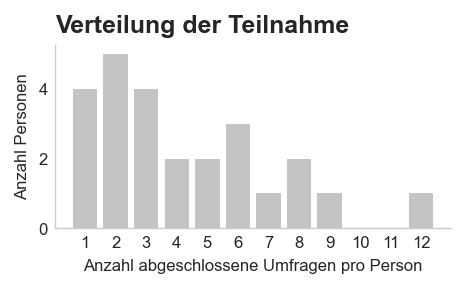

In [1472]:
survey_counts = (
    wide_df.groupby('device_id')['survey_num']
           .nunique()
)

cm = 1 / 2.54  # Umrechnung Zoll → cm

fig, ax = plt.subplots(figsize=(8 * cm, 5 * cm))

ax.bar(
    np.arange(1, survey_counts.max() + 1),
    np.bincount(survey_counts)[1:],
    width=0.8,
    color="#c4c4c4"
)

ax.set_xlabel("Anzahl abgeschlossene Umfragen pro Person")
ax.set_ylabel("Anzahl Personen")
ax.set_title("Verteilung der Teilnahme", fontname="Arial", weight="bold")

ax.set_xticks(np.arange(1, survey_counts.max() + 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.7)
ax.spines['bottom'].set_linewidth(0.7)
ax.grid(False)

plt.tight_layout()
plt.savefig("plots/survey_counts.pdf", bbox_inches="tight")
plt.show()
plt.close(fig)


In [1473]:
slider_cols = [
    'general_wellbeing', 'content', 'tense_relaxed', 'awake',
    'environment_noise', 'environment_nature', 'environment_lively',
    'environmen_pleasure', 'sense_of_belonging'
]

wide_df[slider_cols].describe().T[['mean','std','min','25%','50%','75%','max']].round(2)


,mean,std,min,25%,50%,75%,max
general_wellbeing,0.67,0.19,0.00,0.57,0.69,0.79,1.0
content,0.65,0.22,0.00,0.56,0.67,0.80,1.0
tense_relaxed,0.58,0.24,0.00,0.38,0.62,0.76,1.0
awake,0.46,0.25,0.00,0.29,0.39,0.68,1.0
environment_noise,0.61,0.29,0.00,0.35,0.68,0.87,1.0
environment_nature,0.40,0.31,0.00,0.14,0.37,0.63,1.0
environment_lively,0.54,0.32,0.00,0.26,0.60,0.82,1.0
environmen_pleasure,0.71,0.24,0.01,0.59,0.77,0.90,1.0
sense_of_belonging,0.75,0.26,0.01,0.63,0.81,0.98,1.0


In [1496]:
cat_cols = ['activity', 'location_category', 'indoors_outdoors', 'people_with_you']

def freq_table(df: pd.DataFrame, cols, sep=';'):
    """
    Gibt eine Gesamt-Frequenztabelle zurück:
    - jede Kategorie einzeln (auch wenn Multiple-Choice kombiniert war)
    - n (Anzahl Nennungen)
    - % von Gesamt-N (alle Zeilen im df)
    - % von gültig-N (nur Zeilen, die im jeweiligen Feld nicht NaN sind)
    """
    out = []
    for col in cols:
        n_total = len(df)
        s = df[col]
        valid = s.dropna()
        
        exploded = (
            valid.astype(str)
                 .str.split(sep)
                 .explode()
                 .str.strip()
                 .replace('', np.nan)
        )

        counts = exploded.value_counts(dropna=False)
        n_valid = len(valid)

        tmp = pd.DataFrame({
            'variable': col,
            'category': counts.index,
            'n': counts.values,
            '% of total N': (counts.values / n_total * 100).round(1),
            '% of valid N': (counts.values / n_valid * 100).round(1)
        })
        out.append(tmp)
    return pd.concat(out, ignore_index=True)

freq = freq_table(wide_df, cat_cols)

# (Optional) Für LaTeX aufbereiten:
latex_tbl = (freq.rename(columns={
                    'variable': 'Frage',
                    'category': 'Kategorie',
                    'n': 'Anzahl',
                    '% of total N': 'Prozent (gesamt)',
                    '% of valid N': 'Prozent (gültig)'
                })
                .to_latex(index=False,
                          longtable=True,
                          escape=False,
                          column_format='p{4cm}p{5cm}rrr'))
print(latex_tbl)

\begin{longtable}{p{4cm}p{5cm}rrr}
\toprule
Frage & Kategorie & Anzahl & Prozent (gesamt) & Prozent (gültig) \\
\midrule
\endfirsthead
\toprule
Frage & Kategorie & Anzahl & Prozent (gesamt) & Prozent (gültig) \\
\midrule
\endhead
\midrule
\multicolumn{5}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
activity & working / studying & 53 & 50.000000 & 50.000000 \\
activity & leisure / relaxation & 27 & 25.500000 & 25.500000 \\
activity & travelling / commuting & 12 & 11.300000 & 11.300000 \\
activity & cooking / eating & 8 & 7.500000 & 7.500000 \\
activity & using media & 8 & 7.500000 & 7.500000 \\
activity & social activities & 7 & 6.600000 & 6.600000 \\
activity & housework / tidying & 2 & 1.900000 & 1.900000 \\
activity & resting / sleeping & 2 & 1.900000 & 1.900000 \\
activity & shopping / errands & 2 & 1.900000 & 1.900000 \\
activity & other & 1 & 0.900000 & 0.900000 \\
location_category & school / university & 38 & 35.800000 & 35.800000 \\
location_category

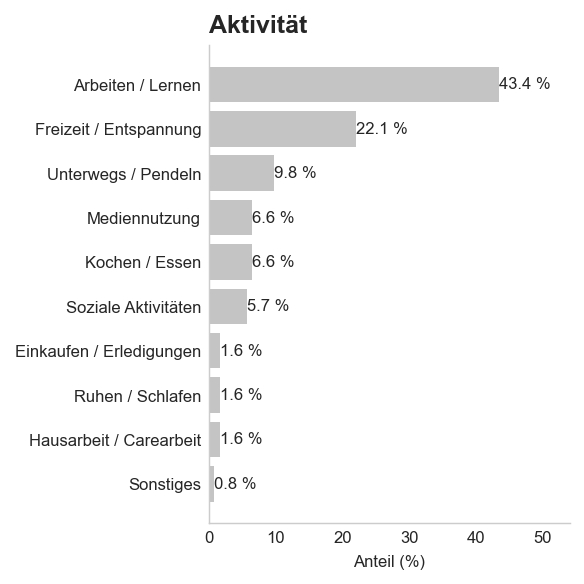

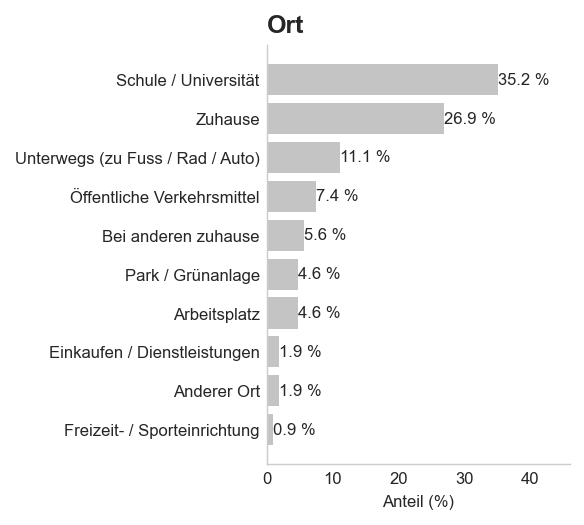

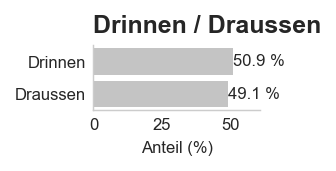

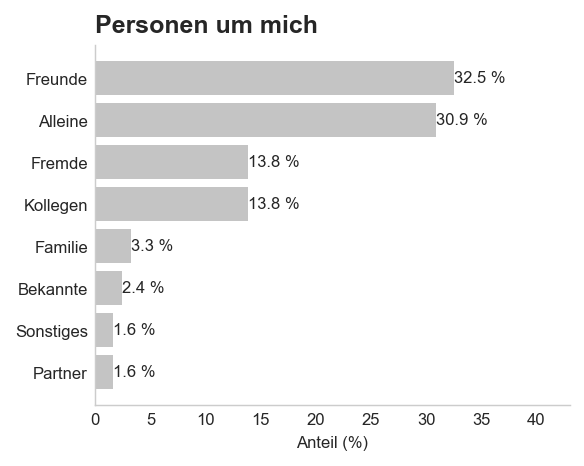

In [1475]:
import matplotlib.pyplot as plt
import numpy as np

# Kategorien (Spalten)
cat_cols = ['activity', 'location_category',
            'indoors_outdoors', 'people_with_you']

# Deutsche Titel für Plots
title_mapping = {
    "activity": "Aktivität",
    "location_category": "Ort",
    "indoors_outdoors": "Drinnen / Draussen",
    "people_with_you": "Personen um mich",
}

# Deutsche Label-Übersetzung
label_mapping = {
    "working / studying": "Arbeiten / Lernen",
    "leisure / relaxation": "Freizeit / Entspannung",
    "travelling / commuting": "Unterwegs / Pendeln",
    "using media": "Mediennutzung",
    "cooking / eating": "Kochen / Essen",
    "social activities": "Soziale Aktivitäten",
    "shopping / errands": "Einkaufen / Erledigungen",
    "resting / sleeping": "Ruhen / Schlafen",
    "housework / tidying": "Hausarbeit / Carearbeit",
    "other": "Sonstiges",
    "school / university": "Schule / Universität",
    "at home": "Zuhause",
    "on the move (foot / bike / car)": "Unterwegs (zu Fuss / Rad / Auto)",
    "public transport": "Öffentliche Verkehrsmittel",
    "at someone else’s home": "Bei anderen zuhause",
    "park / green space": "Park / Grünanlage",
    "workplace": "Arbeitsplatz",
    "shopping / services": "Einkaufen / Dienstleistungen",
    "other place": "Anderer Ort",
    "leisure / sports facility": "Freizeit- / Sporteinrichtung",
    "indoors": "Drinnen",
    "outdoors": "Draussen",
    "friends": "Freunde",
    "alone": "Alleine",
    "strangers": "Fremde",
    "colleagues": "Kollegen",
    "family": "Familie",
    "acquaintances": "Bekannte",
    "partner": "Partner",
    "missing": "Fehlend",
}

# Individuelle Plotgrößen pro Kategorie (in cm)
figsize_by_col = {
    "activity": (10 * cm, 10 * cm),
    "location_category": (10 * cm, 9 * cm),
    "indoors_outdoors": (5 * cm, 3 * cm),
    "people_with_you": (10 * cm, 8 * cm),
}

# Alle Kategorien einzeln plotten
for col in cat_cols:
    # Häufigkeiten berechnen
    counts = (
        wide_df[col]
        .fillna('missing')
        .str.split(';')
        .explode()
        .value_counts()
        .sort_values()
    )
    pct = counts / counts.sum() * 100
    translated_index = pct.index.map(lambda x: label_mapping.get(x, x))

    # Größe aus Mapping
    figsize = figsize_by_col.get(col, (7.5 * cm, 5 * cm))

    # Plot
    fig, ax = plt.subplots(figsize=figsize)

    ax.barh(translated_index, pct.values, color="#c4c4c4")
    ax.set_xlabel("Anteil (%)")
    # Dynamisch: maximaler Wert + Puffer
    xmax = pct.max()
    xlim = np.ceil(xmax + 10)  # +5% Puffer für Text
    ax.set_xlim(0, min(xlim, 100))  # Optional: hart bei 100 deckeln

    ax.set_title(
        title_mapping.get(col, col),
        fontname="Arial",
        weight="bold"
    )

    for y, v in enumerate(pct.values):
        ax.text(v, y, f'{v:.1f} %', va='center', ha='left', fontsize=fontsize)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.7)
    ax.spines['bottom'].set_linewidth(0.7)
    ax.grid(False)

    plt.tight_layout()
    fig.savefig(f"plots/cat_dist_{col}.pdf", bbox_inches="tight")
    plt.show()
    plt.close(fig)
    


## People Data

In [1476]:
import pandas as pd
import numpy as np

# Grundübersicht
print(people_data.shape)                     # Zeilen x Spalten
print(people_data.head())

# Fehlende Werte (in %)
missing_pct = people_data.isna().mean().sort_values(ascending=False)*100
print(missing_pct)


(25, 18)
               age_group  n_surveys     sex     gender sexual_orientation  \
device_id                                                                   
1IIJ-CDFW-46VP   26 – 35          4  female        man  straight / hetero   
1SMH-8HOX-E1HX   16 – 25          3  female        man  straight / hetero   
20LN-4X5H-UXWX   56 – 65          1  female  trans man            asexual   
4RKD-HU7N-HXI2       NaN          1  female        man  straight / hetero   
678K-202G-SYCD   16 – 25          4  female        man  straight / hetero   

                          education household_members  \
device_id                                               
1IIJ-CDFW-46VP    university degree                 3   
1SMH-8HOX-E1HX  Matura / equivalent                 5   
20LN-4X5H-UXWX  Matura / equivalent                 6   
4RKD-HU7N-HXI2  Matura / equivalent                 3   
678K-202G-SYCD  Matura / equivalent  1 (living alone)   

               household_members_financing monthly_

In [1477]:
# Label war falsch zu den Antworten
def flip_sex(val):
    if val == "male":
        return "female"
    elif val == "female":
        return "male"
    return val  # alle anderen bleiben gleich

people_data["sex"] = people_data["sex"].apply(flip_sex)


In [1493]:
import pandas as pd

# 1) Welche Spalten sind kategorial, welche davon Multiple-Choice?
cat_cols = [
    "age_group",
    "gender",
    "sex",
    "sexual_orientation",
    "education",
    "employment_status",
    "monthly_household_income",
    "household_members",
    "household_members_financing",
    "disabilities",
    "different_country_than_born_in",
    "axis_codes",
    "eq_income_group"
]
cat_cols = [c for c in cat_cols if c in people_data.columns]

# Multiple-Choice-Spalten + Trennzeichen
multi_cols = {
    "axis_codes": ";",   # weitere Spalten hier ergänzen, falls nötig
}


def _explode_multichoice(df, col, sep=";"):
    """Hilfsfunktion: Spalte col aufsplitten und als Series zurückgeben."""
    s = df[col].fillna("").astype(str).str.split(sep)
    exploded = s.explode().str.strip()
    return exploded[exploded.ne("")]  # leere Strings raus


def cat_summary(df, cols, multi_cols=None, sort_by="percent", ascending=False):
    """
    Gibt eine zusammengefasste Tabelle (count & %) pro kategorialer Variable zurück.
    Kann Single-Choice und Multiple-Choice Spalten mischen.
    """
    if multi_cols is None:
        multi_cols = {}
    out_frames = []
    n = len(df)  # Basis für Prozentrechnung (Teilnehmer*innen)

    for col in cols:
        if col in multi_cols:  # Multiple-Choice
            exploded = _explode_multichoice(df, col, sep=multi_cols[col])
            vc = exploded.value_counts().rename("count")
            # Prozent relativ zur Anzahl Personen (nicht zur Anzahl Nennungen)
            perc = (vc / n * 100).rename("percent")
        else:  # Single-Choice
            vc = df[col].value_counts(dropna=False).rename("count")
            perc = (vc / n * 100).rename("percent")

        tmp = pd.concat([vc, perc], axis=1)
        tmp["variable"] = col
        tmp["category"] = tmp.index
        tmp = tmp.reset_index(drop=True)

        if sort_by in tmp.columns:
            tmp = tmp.sort_values(by=sort_by, ascending=ascending)

        out_frames.append(tmp)

    result = pd.concat(out_frames, ignore_index=True)
    return result[["variable", "category", "count", "percent"]]


# 2) Tabelle erstellen
summary_table = cat_summary(people_data, cat_cols, multi_cols=multi_cols)

# 3) OPTIONAL: Anzahl Nennungen je Person für Multi-Choice (z. B. axis_codes)
def multichoice_count_table(df, col, sep=";"):
    s = df[col].fillna("").astype(str).str.split(sep)
    num = s.apply(lambda lst: len([x for x in lst if x.strip()]))
    vc = num.value_counts().sort_index().rename("count")
    res = vc.reset_index()
    res.columns = ["category", "count"]
    res["percent"] = res["count"] / len(df) * 100
    res["variable"] = f"{col}_num"
    return res[["variable", "category", "count", "percent"]]

axis_num_tbl = multichoice_count_table(people_data, "axis_codes", sep=";")
summary_table = pd.concat([summary_table, axis_num_tbl], ignore_index=True)



In [1494]:
import pandas as pd

# ============================================================
# 1) Anzahl Kategorien pro Person (0 = keine Diskriminierung)
# ============================================================

def discrimination_count(df, col="axis_codes", sep=";"):
    NO_TOKENS = {"no", "nein", "", "nan"}  # ggf. erweitern
    s = df[col].fillna("").astype(str).str.split(sep)

    def _count_valid(items):
        items = [x.strip() for x in items if x.strip() != ""]
        if len(items) == 0:
            return 0
        # Wenn irgendein "NO_TOKEN" drin steckt, werten wir die ganze Antwort als 0
        if any(x.lower() in NO_TOKENS for x in items):
            return 0
        return len(items)

    counts = s.apply(_count_valid)
    dist = (
        counts.value_counts()
        .sort_index()
        .rename_axis("n_kategorien")
        .reset_index(name="count")
    )
    dist["percent"] = dist["count"] / len(df) * 100
    return counts, dist


# ============================================================
# 2) Häufigkeiten einzelner Kategorien (explodiert & gefiltert)
# ============================================================

def discrimination_category_summary(df, col="axis_codes", sep=";"):
    NO_TOKENS = {"no", "nein", "", "nan"}
    exploded = (
        df[col].fillna("")
        .astype(str)
        .str.split(sep)
        .explode()
        .str.strip()
    )

    exploded = exploded[~exploded.str.lower().isin(NO_TOKENS)]

    # value_counts → DataFrame
    axis_summary = exploded.value_counts(dropna=False).rename("count")
    axis_summary = axis_summary.rename_axis("category").reset_index()
    axis_summary["percent"] = axis_summary["count"] / len(df) * 100
    axis_summary.insert(0, "variable", col)  # sicher "variable" vorn einfügen

    # Spaltenreihenfolge sicherstellen
    axis_summary = axis_summary[["variable", "category", "count", "percent"]]
    return axis_summary


# ============================================================
# 3) Ausführen & ins summary_table hängen (optional)
# ============================================================

axis_counts_per_person, axis_dist_table = discrimination_count(people_data, col="axis_codes", sep=";")
axis_dist_table2 = axis_dist_table.copy()
axis_dist_table2["variable"] = "axis_codes_num"
axis_dist_table2["category"] = axis_dist_table2["n_kategorien"].astype(str)
axis_dist_table2 = axis_dist_table2[["variable", "category", "count", "percent"]]

axis_summary = discrimination_category_summary(people_data, col="axis_codes", sep=";")

# Falls summary_table schon existiert: alte Zeilen rauswerfen, neue anhängen
if 'summary_table' in locals():
    summary_table = summary_table[~summary_table["variable"].isin(["axis_codes", "axis_codes_num"])]
    summary_table = pd.concat([summary_table, axis_summary, axis_dist_table2], ignore_index=True)
else:
    summary_table = pd.concat([axis_summary, axis_dist_table2], ignore_index=True)

# Ausgaben:
display(axis_summary.style.set_caption("axis_codes – Häufigkeiten (aufgesplittet)"))
display(axis_dist_table.style.set_caption("Anzahl unterschiedlicher Diskriminierungsarten pro Person (0 = keine)"))


,variable,category,count,percent
0,axis_codes,gender,4,16.000000
1,axis_codes,language / accent,4,16.000000
2,axis_codes,background,4,16.000000
3,axis_codes,sexual orientation,3,12.000000
4,axis_codes,clothing / style,2,8.000000
5,axis_codes,social / financial,1,4.000000
6,axis_codes,skin / appearance,1,4.000000


,n_kategorien,count,percent
0,0,12,48.000000
1,1,8,32.000000
2,2,4,16.000000
3,3,1,4.000000


In [1495]:

# 4) Anzeigen – pro Variable eine Tabelle
for var, sub in summary_table.groupby("variable"):
    display(sub[["category", "count", "percent"]].style.set_caption(f"{var} – Häufigkeiten"))


,category,count,percent
0,16 – 25,20,80.000000
1,26 – 35,3,12.000000
2,56 – 65,1,4.000000
3,nan,1,4.000000


,category,count,percent
47,gender,4,16.000000
48,language / accent,4,16.000000
49,background,4,16.000000
50,sexual orientation,3,12.000000
51,clothing / style,2,8.000000
52,social / financial,1,4.000000
53,skin / appearance,1,4.000000


,category,count,percent
54,0,12,48.000000
55,1,8,32.000000
56,2,4,16.000000
57,3,1,4.000000


,category,count,percent
39,no,17,68.000000
40,yes,7,28.000000
41,nan,1,4.000000


,category,count,percent
38,no,25,100.000000


,category,count,percent
15,Matura / equivalent,23,92.000000
16,university degree,2,8.000000


,category,count,percent
17,student / pupil,22,88.000000
18,employed,3,12.000000


,category,count,percent
42,Very Low,8,32.000000
43,Unknown,6,24.000000
44,High,5,20.000000
45,Low,4,16.000000
46,Very High,2,8.000000


,category,count,percent
4,man,15,60.000000
5,woman,9,36.000000
6,trans man,1,4.000000


,category,count,percent
26,3,10,40.000000
27,4,6,24.000000
28,2,3,12.000000
29,6,2,8.000000
30,1 (living alone),2,8.000000
31,5,1,4.000000
32,9,1,4.000000


,category,count,percent
33,2 earners,13,52.000000
34,1 earner (myself),6,24.000000
35,3 earners,4,16.000000
36,6 earners,1,4.000000
37,5 earners,1,4.000000


,category,count,percent
19,< CHF 1 500,7,28.000000
20,unknown / prefer not to say,6,24.000000
21,> CHF 10 000,5,20.000000
22,CHF 6 000 – 7 500,2,8.000000
23,CHF 3 000 – 4 500,2,8.000000
24,CHF 1 500 – 3 000,2,8.000000
25,CHF 7 500 – 10 000,1,4.000000


,category,count,percent
7,male,16,64.000000
8,female,8,32.000000
9,nan,1,4.000000


,category,count,percent
10,straight / hetero,17,68.000000
11,gay / lesbian,3,12.000000
12,bisexual,3,12.000000
13,asexual,1,4.000000
14,queer,1,4.000000


In [1481]:
cross = pd.crosstab(people_data["gender"], people_data["age_group"], margins=True)
cross_pct = cross.div(cross.loc["All"], axis=1)*100  # spaltenweise Prozent
print(cross)
print(cross_pct.round(1))


age_group  16 – 25  26 – 35  56 – 65  All
gender                                   
man             12        2        0   14
trans man        0        0        1    1
woman            8        1        0    9
All             20        3        1   24
age_group  16 – 25  26 – 35  56 – 65    All
gender                                     
man           60.0     66.7      0.0   58.3
trans man      0.0      0.0    100.0    4.2
woman         40.0     33.3      0.0   37.5
All          100.0    100.0    100.0  100.0


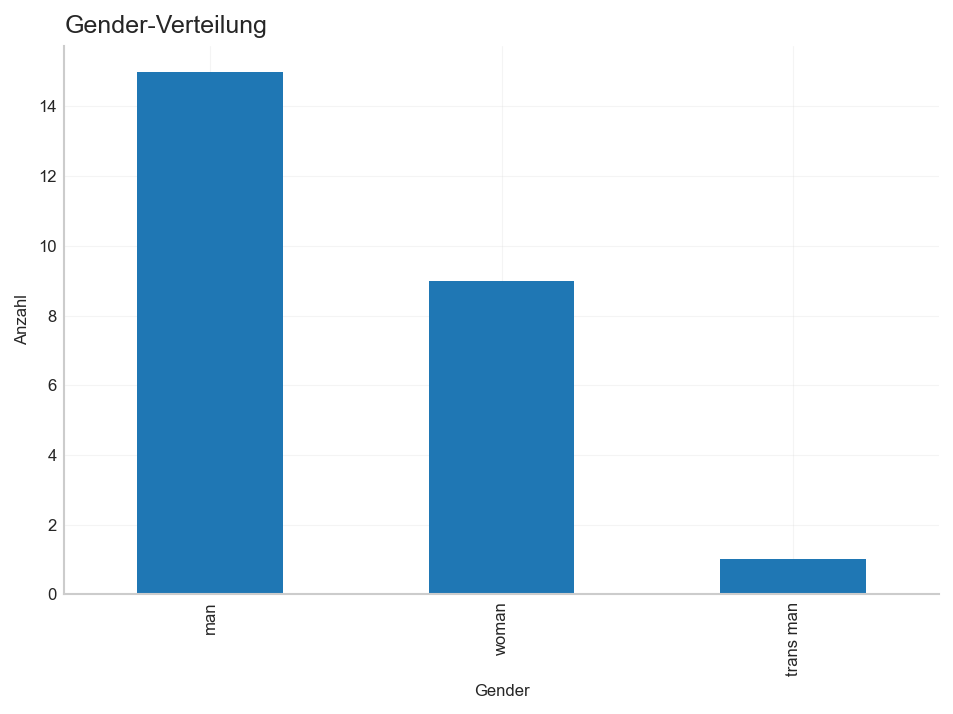

In [1482]:
import matplotlib.pyplot as plt

people_data["gender"].value_counts(dropna=False).plot(kind="bar")
plt.title("Gender-Verteilung")
plt.xlabel("Gender")
plt.ylabel("Anzahl")
plt.tight_layout()
plt.show()


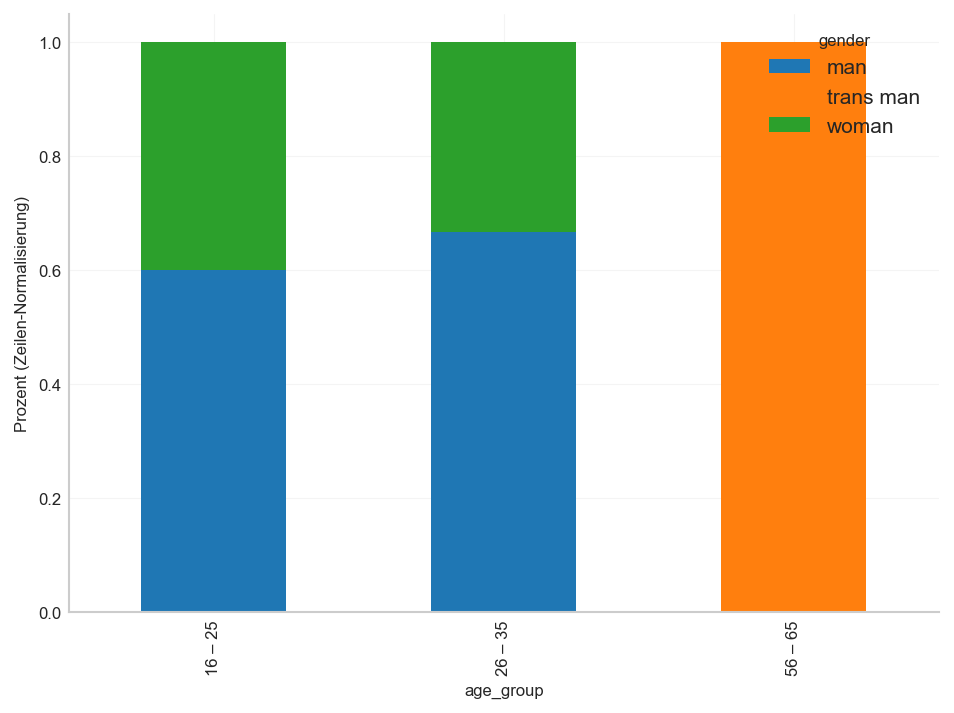

In [1483]:
ct = pd.crosstab(people_data["age_group"], people_data["gender"], normalize="index")
ct.plot(kind="bar", stacked=True)
plt.ylabel("Prozent (Zeilen-Normalisierung)")
plt.tight_layout()
plt.show()


In [1484]:
def table1(df, cat_cols, num_cols):
    # Kategoriale Variablen
    cat_tab = cat_summary(df, cat_cols)
    # Numerische Variablen
    num_tab = df[num_cols].describe().T
    num_tab = num_tab[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
    return cat_tab, num_tab

cat_tab, num_tab = table1(people_data, cat_cols, num_cols)
cat_tab.to_csv("table1_cat.csv", index=False)
num_tab.to_csv("table1_num.csv")


/var/folders/t9/hd1jk7xd203d3n6kn68m9lzc0000gn/T/ipykernel_37035/3440719561.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, vert=False, labels=order, patch_artist=True)


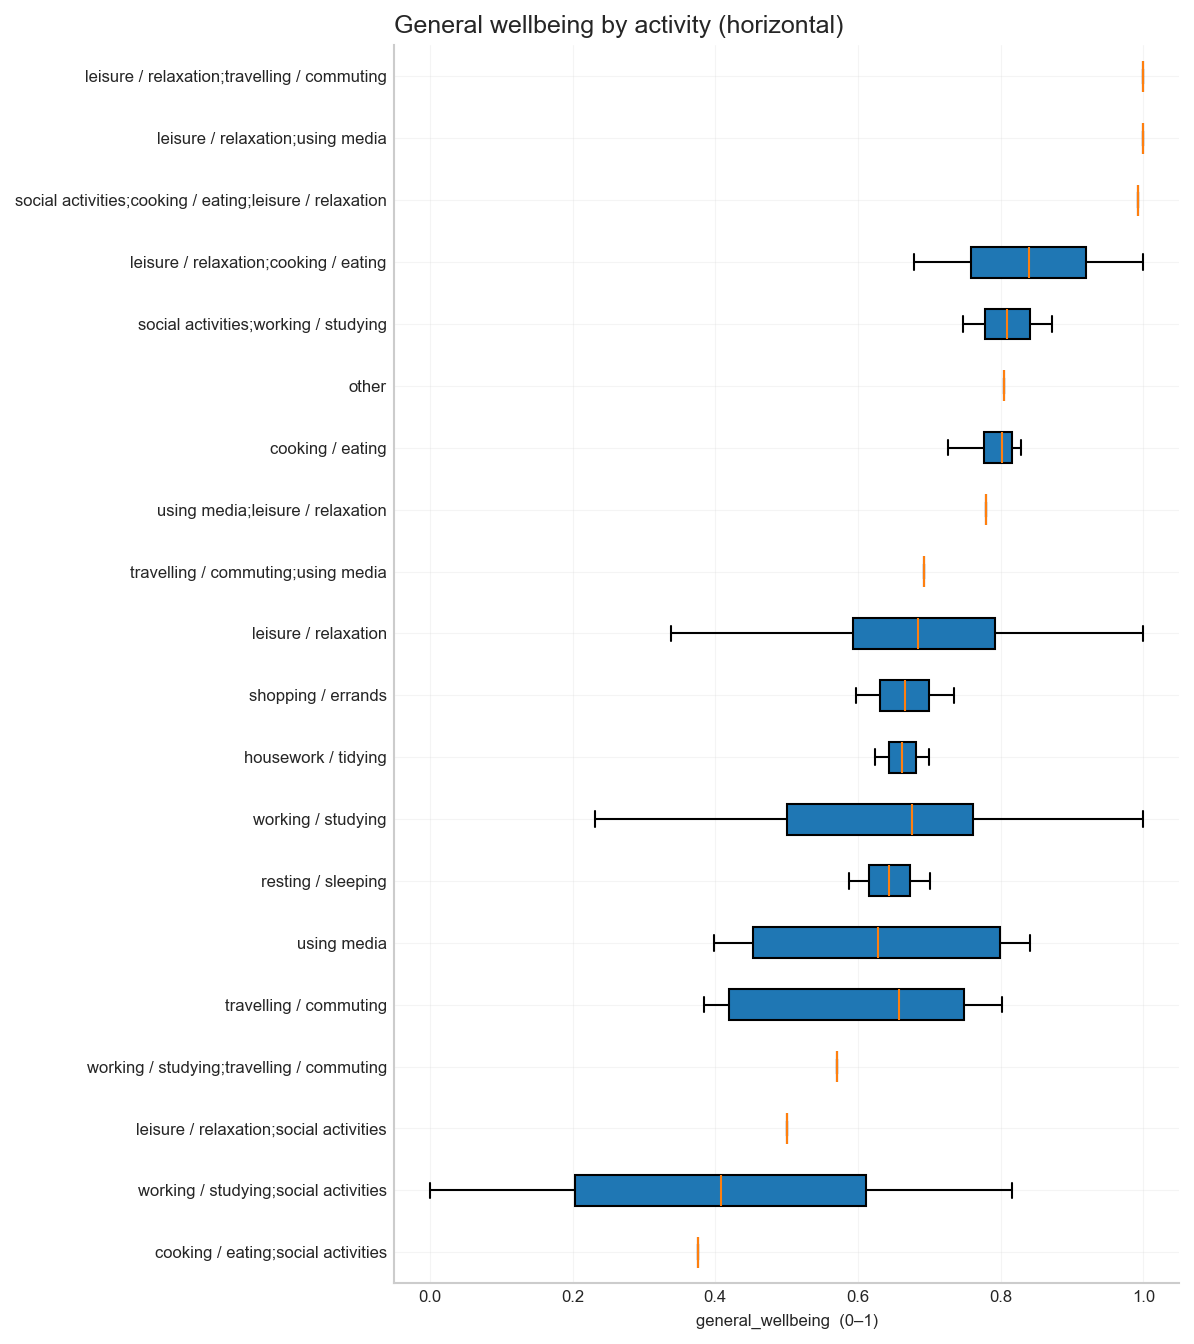

In [1485]:
import matplotlib.pyplot as plt
import pandas as pd

# Reihenfolge nach Mittelwert sortieren
order = (wide_df
         .groupby('activity')['general_wellbeing']
         .mean()
         .sort_values()
         .index.tolist())

# Daten in der gewünschten Reihenfolge einsammeln
data = [wide_df.loc[wide_df['activity'] == act,
                    'general_wellbeing'].dropna()
        for act in order]

fig, ax = plt.subplots(figsize=(8, .45 * len(order)))      # Höhe dynamisch
ax.boxplot(data, vert=False, labels=order, patch_artist=True)

ax.set_xlabel('general_wellbeing  (0–1)')
ax.set_title('General wellbeing by activity (horizontal)')
plt.tight_layout()
plt.show()


Formel (gekürzt): general_wellbeing ~ environment_noise + environment_nature + environment_lively + environmen_pleasure + content + tense_relaxed + awake + se …


/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.198020
  warnings.warn(msg, ConvergenceWarning)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-pack

                                        Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   general_wellbeing
No. Observations:                    106                       Method:                               REML             
No. Groups:                          25                        Scale:                                0.0120           
Min. group size:                     1                         Log-Likelihood:                       13.0174          
Max. group size:                     12                        Converged:                            No               
Mean group size:                     4.2                                                                              
----------------------------------------------------------------------------------------------------------------------
                                                              Coef.    Std.Err.    z    P

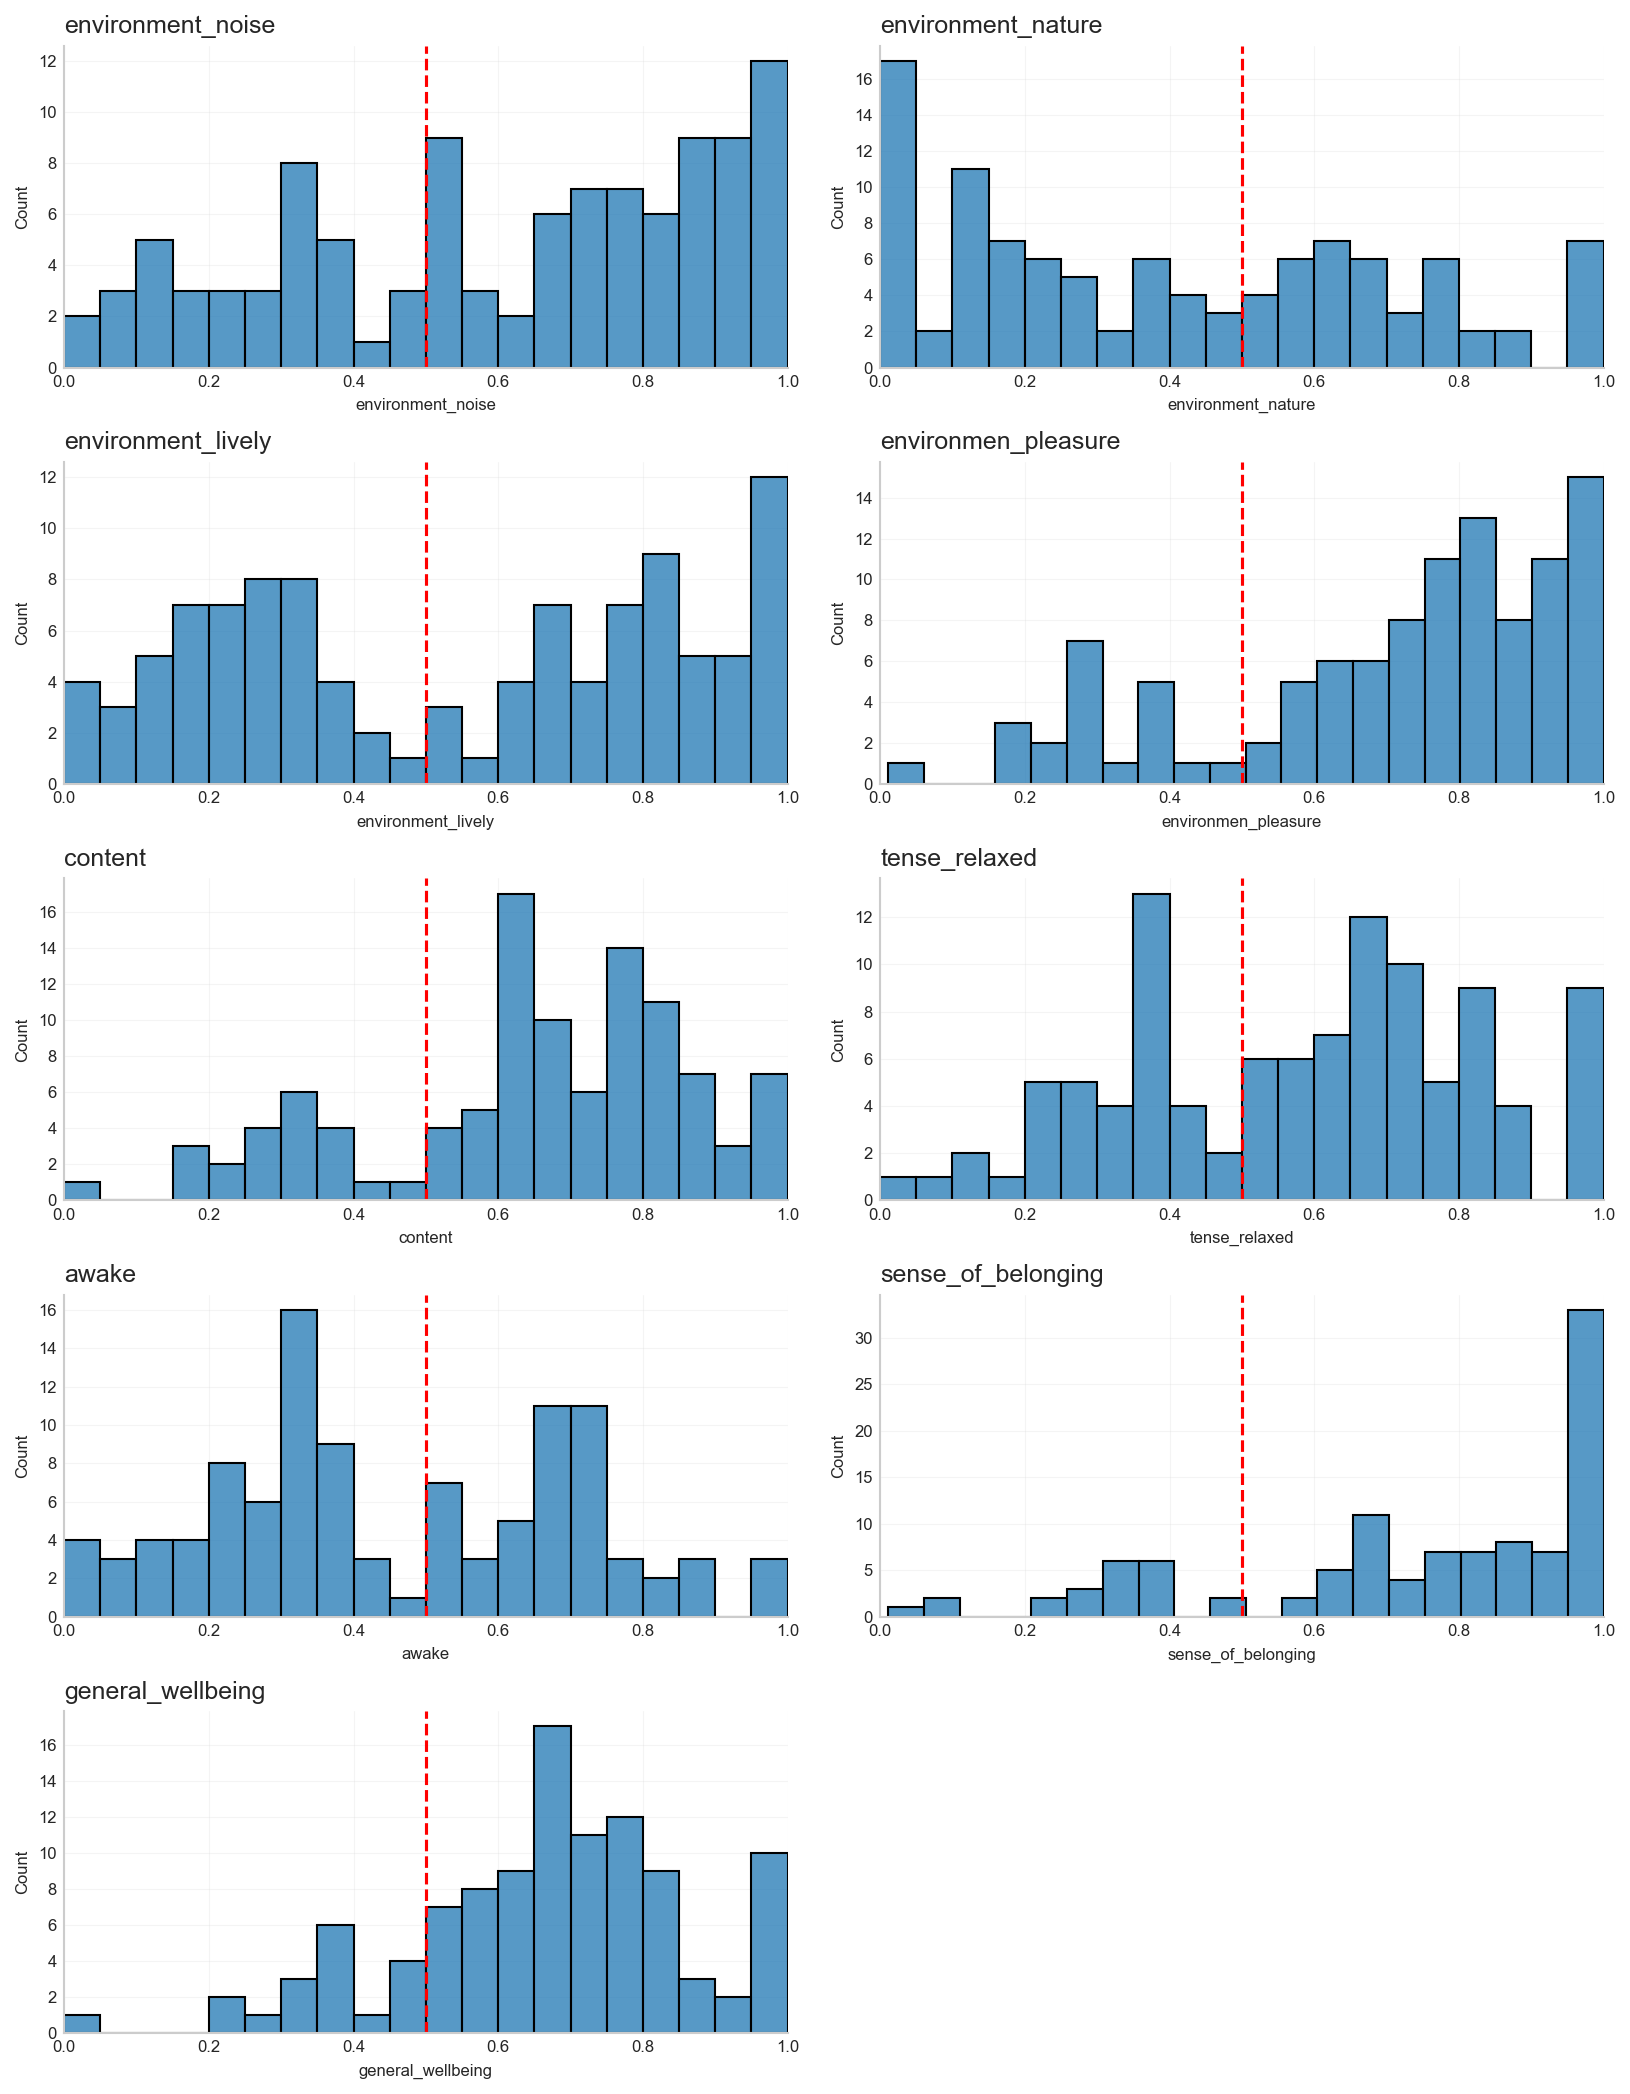

/var/folders/t9/hd1jk7xd203d3n6kn68m9lzc0000gn/T/ipykernel_37035/4267694483.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct, y=labels, ax=ax, palette="Blues_d")
/var/folders/t9/hd1jk7xd203d3n6kn68m9lzc0000gn/T/ipykernel_37035/4267694483.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct, y=labels, ax=ax, palette="Blues_d")
/var/folders/t9/hd1jk7xd203d3n6kn68m9lzc0000gn/T/ipykernel_37035/4267694483.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct, y=labels, ax=ax, palette="Blues_d")
/var/folders/t9/hd1jk7xd203d3n6

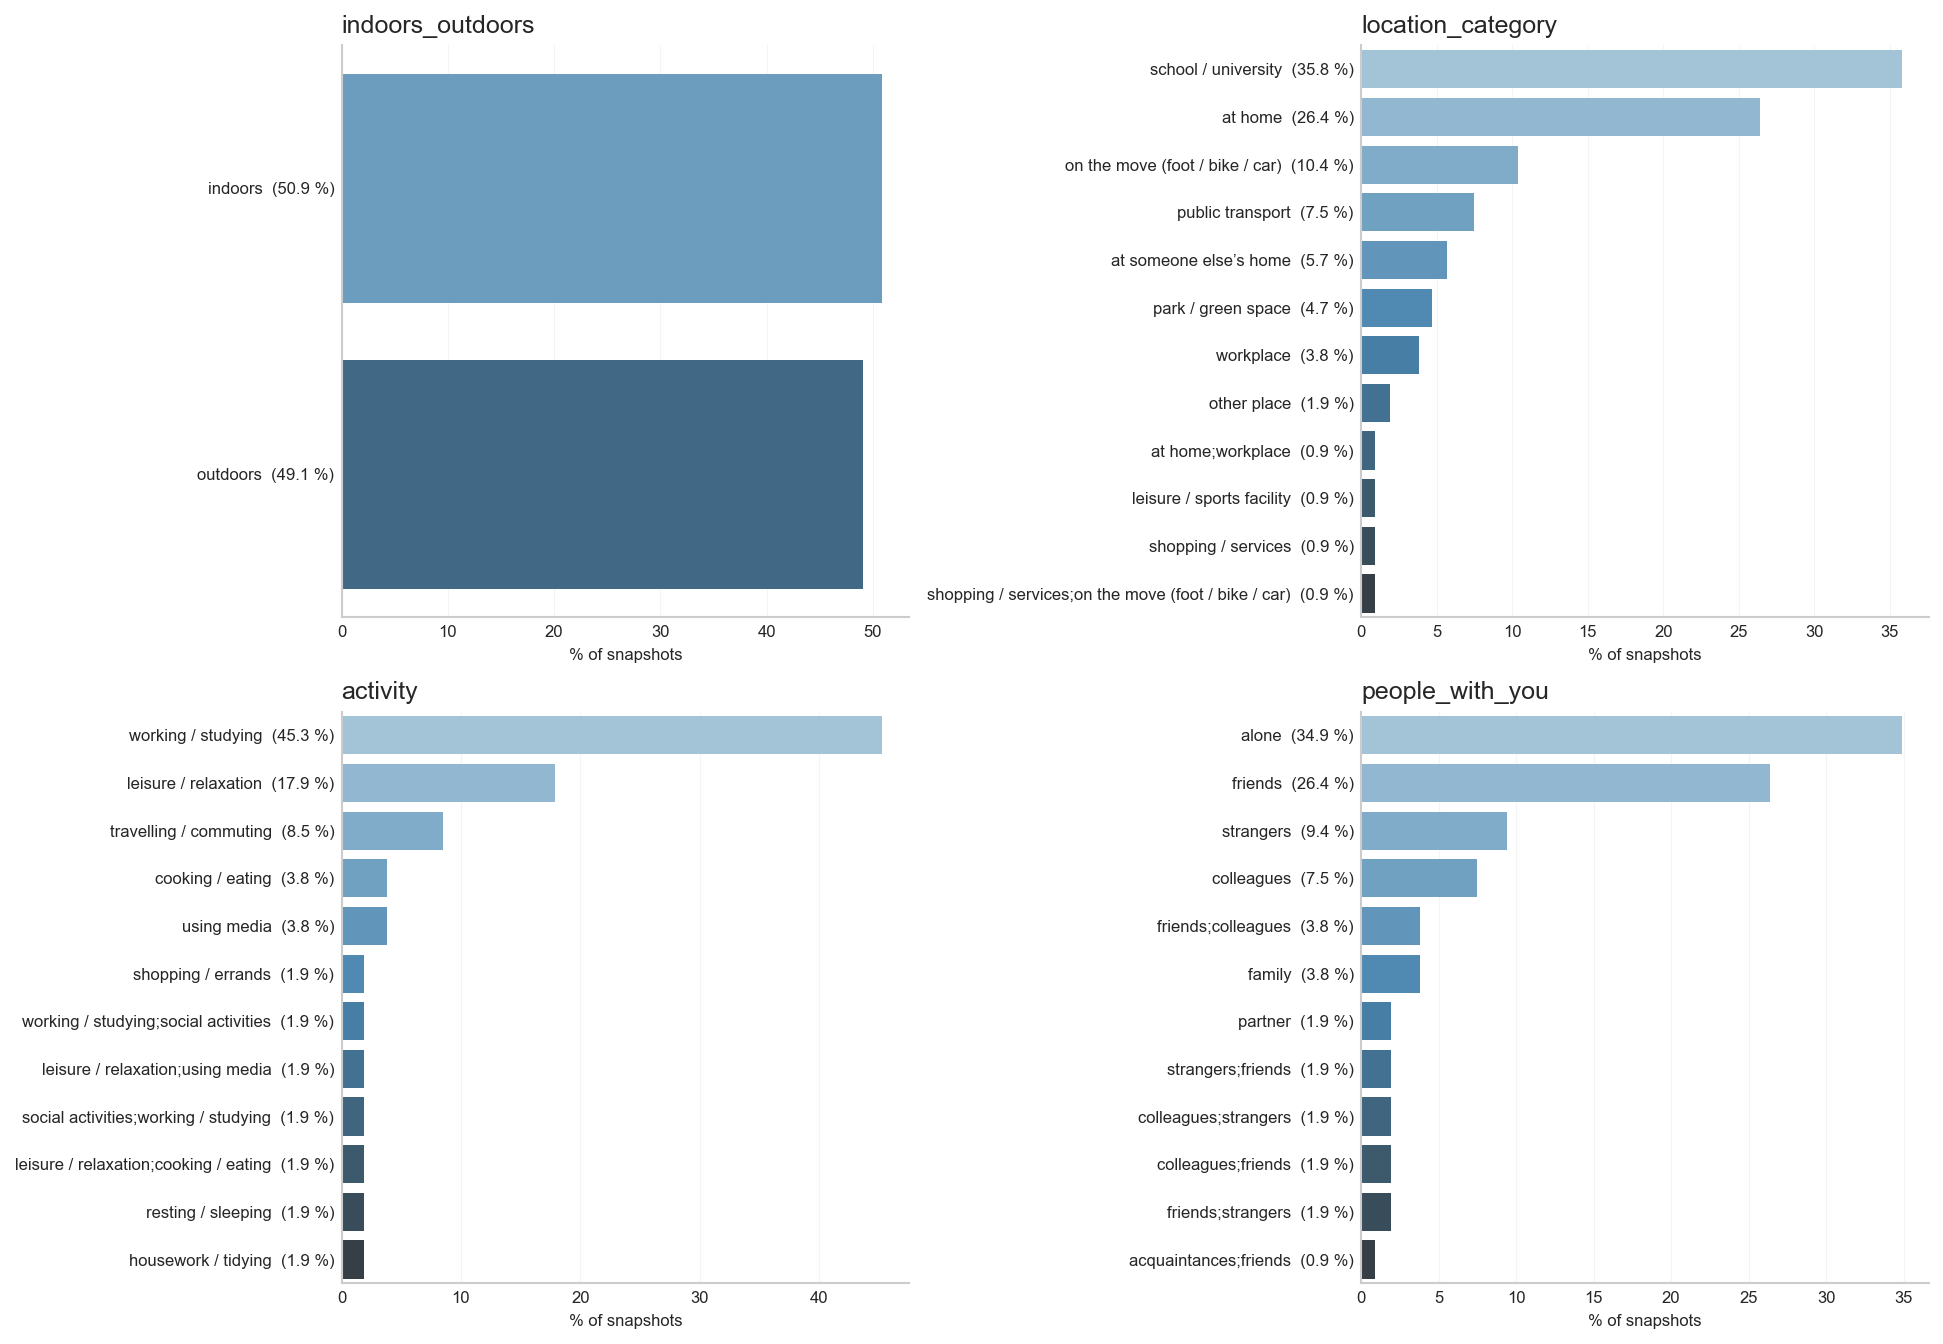

Cramér-V: 0.586


/var/folders/t9/hd1jk7xd203d3n6kn68m9lzc0000gn/T/ipykernel_37035/4267694483.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="coef",y="name",data=sig,
/var/folders/t9/hd1jk7xd203d3n6kn68m9lzc0000gn/T/ipykernel_37035/4267694483.py:126: UserWarning: The palette list has more values (11) than needed (10), which may not be intended.
  sns.barplot(x="coef",y="name",data=sig,


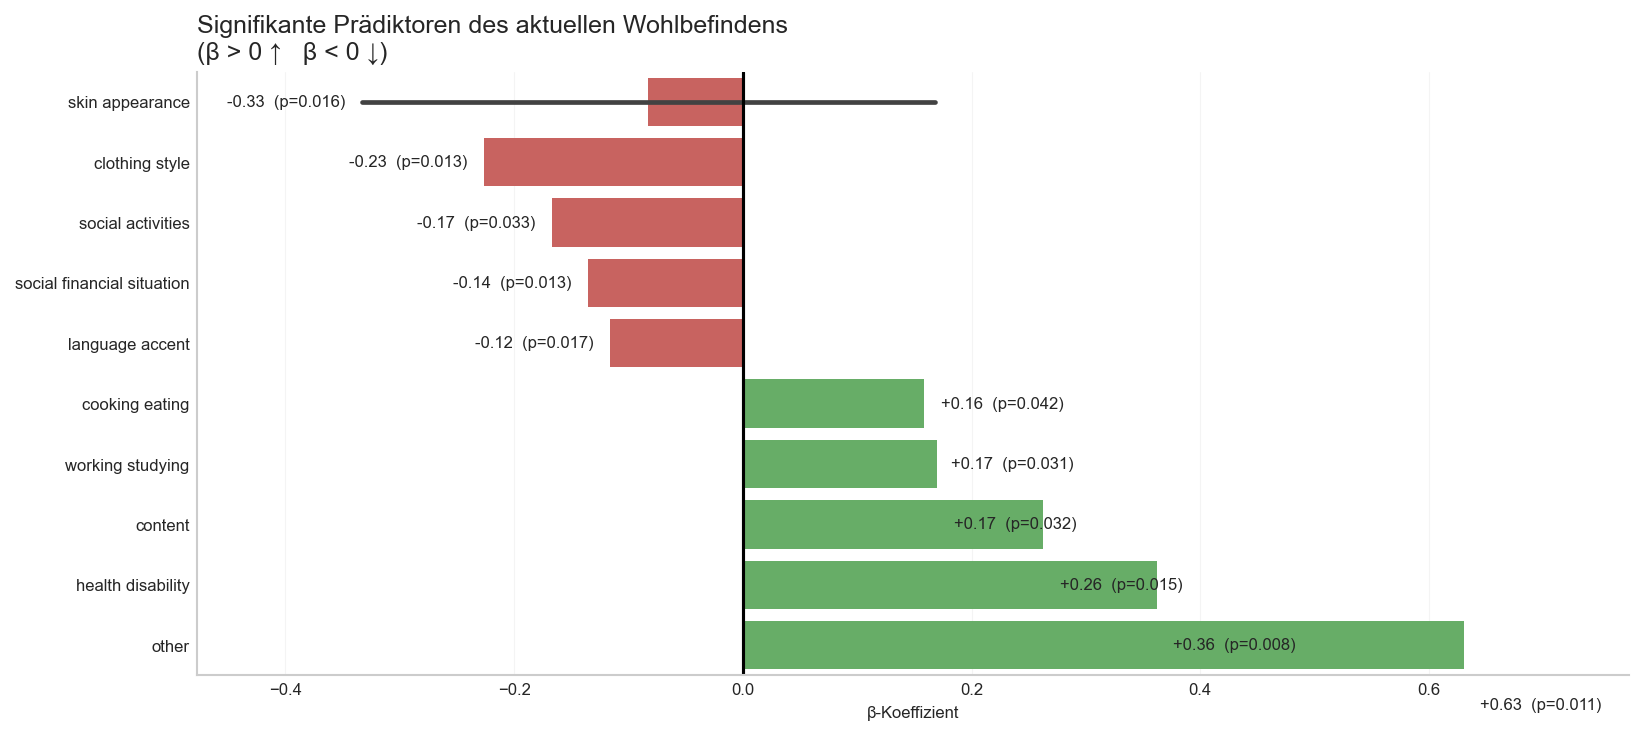

In [1486]:
###############################################################################
# ANALYSE-BLOCK  –  inkl. Mixed-Effects-Modell + Plots                        #
###############################################################################
import re, json, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency, norm

# ---------------------------------------------------------------------------
# 0) SPALTENLISTEN, SLUG-Helfer, Plottechnik
# ---------------------------------------------------------------------------
slider_cols  = ["environment_noise", "environment_nature", "environment_lively",
                "environmen_pleasure", "content", "tense_relaxed", "awake",
                "sense_of_belonging", "general_wellbeing"]

single_cat   = ["indoors_outdoors", "location_category"]
multi_cat    = ["activity", "people_with_you",
                "factors_sense_of_belonging", "majority_comparison"]

def slug(txt: str) -> str:
    return re.sub(r"__+", "_",
           re.sub(r"[^A-Za-z0-9_]+", "_", txt)).strip("_").lower()

# ----------  kleine Hilfs-Funktion für Balkenplots (jetzt GANZ OBEN!) -------
def bar_pct(series, title, ax, top_n=12):
    """Balkenplot mit Prozentangabe im Label."""
    vc   = series.value_counts(dropna=False).head(top_n)
    pct  = (vc/len(series)*100).round(1)
    labels = [f"{idx}  ({p} %)" for idx, p in zip(vc.index, pct)]
    sns.barplot(x=pct, y=labels, ax=ax, palette="Blues_d")
    ax.set_title(title);  ax.set_xlabel("% of snapshots")

# ---------------------------------------------------------------------------
# 1) SLIDER in numerisch, auf Neutralwert 0 zentriert (0.5 → 0)
# ---------------------------------------------------------------------------
df = wide_df.copy()
df[slider_cols] = df[slider_cols].apply(pd.to_numeric, errors="coerce") - 0.5

# ---------------------------------------------------------------------------
# 2) DESIGN-MATRIX  X  (Slider + One-Hot für alle Kategorien)
# ---------------------------------------------------------------------------
X_parts = [df[[c for c in slider_cols if c != "general_wellbeing"]]]

for col in single_cat:
    X_parts.append(pd.get_dummies(df[col], prefix=slug(col), drop_first=True))

def explode_multiselect(series):
    codes = (series.dropna().str.split(";").explode().str.strip().unique())
    dummy = pd.DataFrame(0, index=series.index, columns=codes)
    for idx, cell in series.items():
        if pd.isna(cell): continue
        for c in cell.split(";"): dummy.at[idx, c.strip()] = 1
    return dummy.add_prefix(f"{slug(series.name)}_")

for col in multi_cat:
    X_parts.append(explode_multiselect(df[col]))

X = pd.concat(X_parts, axis=1).astype(float)
X.columns = [slug(c) for c in X.columns]

# ---------------------------------------------------------------------------
# 3) Intersection-Beispiel  (Gender ∩ Age)
# ---------------------------------------------------------------------------
df["oppress_gender_and_age"] = (
    df["axis_of_opression"].fillna("").str.contains("gender") &
    df["axis_of_opression"].str.contains("age")
).astype(int)
X["oppress_gender_and_age"] = df["oppress_gender_and_age"]

# ---------------------------------------------------------------------------
# 4) Mixed-Effects-Modell
# ---------------------------------------------------------------------------
y       = df["general_wellbeing"]
groups  = df["device_id"]
data_m  = pd.concat([y.rename("general_wellbeing"), groups, X], axis=1).dropna()

formula = "general_wellbeing ~ " + " + ".join(X.columns)
print("Formel (gekürzt):", formula[:140], "…")

mfit = smf.mixedlm(formula, data=data_m,
                   groups=data_m["device_id"],
                   re_formula="1").fit(method="lbfgs")
print(mfit.summary())

# ---------------------------------------------------------------------------
# 5) Histos der Slider (rote Linie = neutral 0.5)
# ---------------------------------------------------------------------------
fig, axes = plt.subplots((len(slider_cols)-1)//2+1, 2, figsize=(11,14)); axes=axes.flatten()
for ax, col in zip(axes, slider_cols):
    sns.histplot(wide_df[col], bins=20, ax=ax)
    ax.axvline(0.5, ls="--", c="red"); ax.set(title=col, xlim=(0,1))
for ax in axes[len(slider_cols):]: ax.axis("off")
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------------
# 6) Balkenplots – jetzt ohne NameError
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(13,9)); axes=axes.flatten()
cols_plot = single_cat + ["activity", "people_with_you"]
for ax, col in zip(axes, cols_plot):
    bar_pct(df[col].fillna("Missing"), col, ax)
for ax in axes[len(cols_plot):]: ax.axis("off")
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------------
# 7) Beispiel-Cramér-V  (activity × location_category)
# ---------------------------------------------------------------------------
def cramers_v(x,y):
    tab=pd.crosstab(x,y); chi2=chi2_contingency(tab,False)[0]
    n=tab.to_numpy().sum(); r,k=tab.shape
    return np.sqrt(chi2/(n*(min(r,k)-1)))
print("Cramér-V:", cramers_v(df["activity"].fillna("None"),
                              df["location_category"].fillna("None")).round(3))

# ---------------------------------------------------------------------------
# 8) Signifikante Fixed-Effects hübsch plotten
# ---------------------------------------------------------------------------
fe = pd.DataFrame({"coef": mfit.fe_params, "se": mfit.bse_fe})
fe["p"] = 2*(1-norm.cdf(np.abs(fe["coef"]/fe["se"])))
sig = fe[fe["p"]<.05].sort_values("coef")
if sig.empty:
    print("Keine signifikanten Effekte.")
else:
    def nice(n): return re.sub(r"^(factors_sense_of_belonging_|majority_comparison_|location_category_|people_with_you_|activity_)", "", n).replace("_"," ")
    sig["name"]=sig.index.map(nice); rng=sig["coef"].max()-sig["coef"].min(); pad=rng*0.15 or 0.2
    plt.figure(figsize=(11,max(2.5,len(sig)*0.45)))
    sns.barplot(x="coef",y="name",data=sig,
                palette=["#d9534f" if c<0 else "#5cb85c" for c in sig["coef"]])
    plt.axvline(0,c="k"); plt.xlim(sig["coef"].min()-pad,sig["coef"].max()+pad)
    for y,(c,p) in enumerate(zip(sig["coef"],sig["p"])):
        plt.text(c+np.sign(c)*pad*0.1, y, f"{c:+.2f}  (p={p:.3f})",
                 va="center", ha="left" if c>0 else "right")
    plt.title("Signifikante Prädiktoren des aktuellen Wohlbefindens\n(β > 0 ↑   β < 0 ↓)")
    plt.xlabel("β-Koeffizient"); plt.ylabel(""); plt.tight_layout(); plt.show()


In [1487]:
###############################################################################
# FREITEXT-ANTWORTEN SAMMELN (other_factors_*  –  930 & 940)                  #
###############################################################################
import pandas as pd

# ❶ Spalten, die Freitext enthalten
free_cols = ["other_factors_negative", "other_factors_positive"]

# ❷ Säubern-Funktion: NaNs raus, Leerraum trimmen, Zeilenumbrüche ersetzen
def collect_text(series: pd.Series) -> list[str]:
    return (series.dropna()                  # NaN entfernen
                  .astype(str)               # sicher als String
                  .str.replace(r"\s+", " ", regex=True)  # Mehrfach-Whitespace → Space
                  .str.strip()               # vorne/hinten trimmen
                  .loc[lambda s: s != ""]    # leere Strings verwerfen
                  .unique()                  # Duplikate entfernen
                  .tolist())

# ❸ Ergebnisse als Dictionary – übersichtlicher & weiterverwendbar
free_text_responses = {col: collect_text(wide_df[col]) for col in free_cols}

# ❹ Ausgabe
for col, lst in free_text_responses.items():
    print(f"\n— {col}  ({len(lst)} einzigartige Antworten) —")
    for i, txt in enumerate(lst, 1):
        print(f"{i:>2}. {txt}")



— other_factors_negative  (11 einzigartige Antworten) —
 1. heat
 2. Everyone is doing the same, so it kind of feels like being at the right place
 3. The contact with strangers
 4. Bed
 5. health issues
 6. no natural sunlight room without windows no fresh air
 7. a lot of people - personal space
 8. No
 9. /
10. no
11. Not really

— other_factors_positive  (7 einzigartige Antworten) —
 1. place i know and is mine i have control over it
 2. know this place and can do what i want
 3. my room and cozy for the night
 4. pets
 5. spending time with family pets
 6. I am not by myself
 7. Less noise from construction works


In [1488]:
###############################################################################
# INTERAKTIVE KARTE MIT ALLEN SURVEYS (Folium + MarkerCluster)                #
###############################################################################
import folium
from folium.plugins import MarkerCluster
import pandas as pd

# ------------------------------------------------------------------
# 1) Koordinaten filtern
# ------------------------------------------------------------------
cols_geo = ["location_lat", "location_lng", "survey_created_at",
            "device_id", "activity", "general_wellbeing"]
geo_df = (wide_df[cols_geo]
          .dropna(subset=["location_lat","location_lng"]))

print(f"{len(geo_df):,} Surveys mit Geo-Daten gefunden.")

# ------------------------------------------------------------------
# 2) Grundkarte zentrieren
# ------------------------------------------------------------------
center = [geo_df["location_lat"].mean(), geo_df["location_lng"].mean()]
m = folium.Map(location=center, zoom_start=9, tiles="CartoDB positron")

# ------------------------------------------------------------------
# 3) MarkerCluster mit Pop-ups
# ------------------------------------------------------------------
mc = MarkerCluster().add_to(m)

for _, row in geo_df.iterrows():
    popup = folium.Popup(
        f"<b>{row['activity']}</b><br>"
        f"wb&nbsp;= {row['general_wellbeing']:.2f}<br>"
        f"{pd.to_datetime(row['survey_created_at']).strftime('%Y-%m-%d&nbsp;%H:%M')}"
        f"<br>device&nbsp;= {row['device_id']}",
        max_width=80
    )
    folium.CircleMarker(
        location=[row["location_lat"], row["location_lng"]],
        radius=4, weight=1, color="#3388ff", fill=True, fill_opacity=0.7,
        popup=popup
    ).add_to(mc)

# ------------------------------------------------------------------
# 4) Karte anzeigen
# ------------------------------------------------------------------
m


106 Surveys mit Geo-Daten gefunden.


# MAIHDA

Mergen der beiden Datensätze

In [1489]:
df = survey_answers.merge(people_data, on="device_id", how="left")

df

,device_id,survey_num,survey_created_at,location_lat,location_lng,activity,awake,axis_of_opression,content,environmen_pleasure,environment_lively,environment_nature,environment_noise,factors_sense_of_belonging,general_wellbeing,indoors_outdoors,location_category,majority_comparison,other_factors_negative,other_factors_positive,people_with_you,sense_of_belonging,tense_relaxed,age_group,n_surveys,sex,gender,sexual_orientation,education,household_members,household_members_financing,monthly_household_income,employment_status,disabilities,axis_codes,different_country_than_born_in,hh_members,income_mid,eq_scale,eq_income,eq_income_group
0,1IIJ-CDFW-46VP,1,2025-05-13 07:48:25.865281,46.950286,7.438392,working / studying,0.830619,axis_of_opression_no,0.775244,0.879479,0.105863,0.599349,0.342020,no,0.724756,outdoors,workplace,gender;age;skin / appearance;sexual orientatio...,NaN,NaN,colleagues,0.936482,0.775244,26 – 35,4.0,male,man,straight / hetero,university degree,3,2 earners,> CHF 10 000,employed,no,no,no,3.0,11000.0,2.0,5500.000000,Very High
1,1IIJ-CDFW-46VP,2,2025-05-13 12:52:34.345000,46.947910,7.377243,working / studying,0.565147,NaN,0.654723,0.289902,0.289902,0.392508,0.078176,no,0.687296,outdoors,on the move (foot / bike / car),gender;skin / appearance;language / accent;hea...,heat,NaN,colleagues,0.631922,0.667752,26 – 35,4.0,male,man,straight / hetero,university degree,3,2 earners,> CHF 10 000,employed,no,no,no,3.0,11000.0,2.0,5500.000000,Very High
2,1IIJ-CDFW-46VP,3,2025-05-16 06:30:37.765026,46.961244,7.451015,cooking / eating,0.563518,NaN,0.825733,0.912052,0.701954,0.442997,0.785016,no,0.811075,indoors,at home,age;background;skin / appearance;language / ac...,NaN,NaN,partner,1.000000,0.825733,26 – 35,4.0,male,man,straight / hetero,university degree,3,2 earners,> CHF 10 000,employed,no,no,no,3.0,11000.0,2.0,5500.000000,Very High
3,1IIJ-CDFW-46VP,4,2025-05-16 12:40:51.991116,46.961188,7.451114,leisure / relaxation,0.874593,NaN,0.838762,0.915309,0.827362,0.804560,0.804560,no,0.786645,indoors,at home,alone (no comparison),NaN,NaN,alone,1.000000,0.899023,26 – 35,4.0,male,man,straight / hetero,university degree,3,2 earners,> CHF 10 000,employed,no,no,no,3.0,11000.0,2.0,5500.000000,Very High
4,1SMH-8HOX-E1HX,1,2025-05-13 07:41:56.654428,46.950313,7.438403,working / studying,0.406154,axis_of_opression_yes_because_of_my_social_or_...,0.595897,0.394872,0.530256,0.367179,0.343590,no,0.595897,outdoors,school / university,age;background;language / accent;health / disa...,NaN,NaN,friends,0.664615,0.372308,16 – 25,3.0,male,man,straight / hetero,Matura / equivalent,5,2 earners,> CHF 10 000,student / pupil,no,social / financial,no,5.0,11000.0,3.0,3666.666667,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,WKQ6-BDTU-V3TK,1,2025-05-13 07:41:34.426913,46.950367,7.438322,working / studying,0.730562,axis_of_opression_yes_because_of_my_background,0.187416,0.631535,0.152952,0.304654,0.141665,background,0.816948,outdoors,school / university,age,NaN,NaN,friends;colleagues,0.693991,0.730562,16 – 25,1.0,male,man,straight / hetero,Matura / equivalent,4,2 earners,unknown / prefer not to say,student / pupil,no,background,no,4.0,NaN,2.5,NaN,Unknown
102,WV4Q-KXF8-LDQA,1,2025-05-13 07:42:40.726444,46.950064,7.438608,social activities;working / studying,0.778502,axis_of_opression_yes_because_of_my_sexual_ori...,0.851249,0.916395,0.728556,0.678610,0.831705,other reason,0.747014,outdoors,school / university,gender;age;skin / appearance,NaN,NaN,friends;strangers,0.269272,0.466884,16 – 25,3.0,male,man,gay / lesbian,Matura / equivalent,4,2 earners,unknown / prefer not to say,student / pupil,no,sexual orientation;clothing / style,no,4.0,NaN,2.5,NaN,Unknown
103,WV4Q-KXF8-LDQA,2,2025-05-14 06:30:07.517644,46.690834,7.869018,social activities;working / studying,0.717698,NaN,0.861021,0.726384,0.180239,1.000000,0.887079,no,0.871878,outdoors

## Strata definieren

In [1490]:

axes = [
    "sex",
    "gender",
    "sexual_orientation",
    "education",
    "eq_income_group",
    "employment_status",
    "different_country_than_born_in",
    "disabilities"
]

# Missing konsistent behandeln
for col in axes:
    df[col] = df[col].fillna("missing").astype("category")

# Stratum-ID
df["stratum"] = df[axes].astype(str).agg("|".join, axis=1)
df["stratum_id"] = df["stratum"].astype("category").cat.codes

# Person-ID als Kategorie (Level 2)
df["person_id"] = df["device_id"].astype("category").cat.codes

# Personenebene-Dataframe
people_tmp = people_data.copy()
for col in axes:
    people_tmp[col] = people_tmp[col].fillna("missing").astype("category")
people_tmp["stratum"] = people_tmp[axes].astype(str).agg("|".join, axis=1)

stratum_sizes = people_tmp["stratum"].value_counts().rename("n_persons").reset_index().rename(columns={"index":"stratum"})
print(stratum_sizes.describe())
print(stratum_sizes[stratum_sizes["n_persons"]<3].head())



       n_persons
count   20.00000
mean     1.25000
std      0.55012
min      1.00000
25%      1.00000
50%      1.00000
75%      1.00000
max      3.00000
                                             stratum  n_persons
1  male|man|straight / hetero|Matura / equivalent...          2
2  male|man|straight / hetero|Matura / equivalent...          2
3  female|woman|straight / hetero|Matura / equiva...          2
4  male|man|straight / hetero|university degree|V...          1
5  female|woman|straight / hetero|Matura / equiva...          1


Zellgrössen checken (auf Personenebene)

In [1491]:

axes = [
    "gender",
    "age_group"
]

# Missing konsistent behandeln
for col in axes:
    df[col] = df[col].fillna("missing").astype("category")

# Stratum-ID
df["stratum"] = df[axes].astype(str).agg("|".join, axis=1)
df["stratum_id"] = df["stratum"].astype("category").cat.codes

# Person-ID als Kategorie (Level 2)
df["person_id"] = df["device_id"].astype("category").cat.codes

# Personenebene-Dataframe
people_tmp = people_data.copy()
for col in axes:
    people_tmp[col] = people_tmp[col].fillna("missing").astype("category")
people_tmp["stratum"] = people_tmp[axes].astype(str).agg("|".join, axis=1)

stratum_sizes = people_tmp["stratum"].value_counts().rename("n_persons").reset_index().rename(columns={"index":"stratum"})
print(stratum_sizes.describe())
print(stratum_sizes[stratum_sizes["n_persons"]<3].head())



       n_persons
count   6.000000
mean    4.166667
std     4.708149
min     1.000000
25%     1.000000
50%     1.500000
75%     6.500000
max    12.000000
             stratum  n_persons
2        man|26 – 35          2
3  trans man|56 – 65          1
4        man|missing          1
5      woman|26 – 35          1


16 unterschiedliche Strata mit durchschnittlich nur 1.5 Personen pro Stratum. Das ist zu wenig um eine gute Analyse durchzuführen.

Hier deshalb nur noch auf altersgruppe und gender reduziert.

In [1492]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# -----------------------------
# 0) Settings
# -----------------------------
axes = ["gender", "age_group"]   # Stratum-Achsen
outcomes = [
    "sense_of_belonging",
    "environmen_pleasure",
    "environment_lively",
    "environment_nature",
    "environment_noise"
]

# -----------------------------
# 1) Stratum bauen
# -----------------------------
for c in axes:
    df[c] = df[c].fillna("missing").astype("category")

df["stratum"]    = df[axes].astype(str).agg("|".join, axis=1)
df["stratum_id"] = df["stratum"].astype("category").cat.codes

# -----------------------------
# 2) Funktion: 2-Level-MAIHDA (nur Stratum als RE)
# -----------------------------
def maihda_two_level(y, data):
    d = data.dropna(subset=[y]).copy()
    # Nullmodell
    mA = smf.mixedlm(f"{y} ~ 1", d, groups=d["stratum_id"])
    rA = mA.fit(method="lbfgs")
    
    # Additives Modell (age_group + gender)
    fe = " + ".join([f"C({v})" for v in axes])
    mB = smf.mixedlm(f"{y} ~ {fe}", d, groups=d["stratum_id"])
    rB = mB.fit(method="lbfgs")
    
    # Varianzen
    vsA = rA.cov_re.iloc[0,0]    # Stratum-Varianz Null
    veA = rA.scale               # Residual-Varianz Null
    VPC_A = vsA / (vsA + veA)

    vsB = rB.cov_re.iloc[0,0]    # Stratum-Varianz additiv
    veB = rB.scale
    VPC_B = vsB / (vsB + veB)
    PCV   = (vsA - vsB) / vsA if vsA > 0 else np.nan

    return {
        "outcome": y,
        "VPC_null": VPC_A,
        "VPC_add":  VPC_B,
        "PCV":      PCV,
        "n_rows": len(d),
        "n_strata": d["stratum"].nunique()
    }, rA, rB

# -----------------------------
# 3) Alle Outcomes laufen lassen
# -----------------------------
rows = []
fitsA, fitsB = {}, {}
for y in outcomes:
    try:
        stats, rA, rB = maihda_two_level(y, df)
        rows.append(stats)
        fitsA[y] = rA
        fitsB[y] = rB
        print(f"{y}: ok")
    except Exception as e:
        print(f"{y}: FAIL -> {e}")

results = pd.DataFrame(rows)
print(results)


sense_of_belonging: ok
environmen_pleasure: ok


/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_

environment_lively: ok
environment_nature: ok
environment_noise: ok
               outcome      VPC_null       VPC_add           PCV  n_rows  \
0   sense_of_belonging  1.238020e-05  1.152781e-06  9.069955e-01     106   
1  environmen_pleasure  3.592826e-33  4.400073e-07 -1.212515e+26     106   
2   environment_lively  2.947505e-04  3.433737e-05  8.821842e-01     106   
3   environment_nature  1.026001e-02  1.122236e-06  9.998901e-01     106   
4    environment_noise  1.948225e-02  2.977120e-05  9.984958e-01     106   

   n_strata  
0         6  
1         6  
2         6  
3         6  
4         6  


/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/luba/.asdf/installs/python/3.13.4t/lib/python3.13t/site-packages/statsmodels/regression/mixed_linear_model.py:2237: Convergen